##  CASE STUDY-BANKING 
## CREDIT CARD SPEND PREDICTION & IDENTIFY DRIVERS FOR SPEND 

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

import statsmodels.formula.api as sm
import scipy.stats as stats
import pandas_profiling 


import seaborn as sns
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

<Figure size 720x540 with 0 Axes>

In [2]:
pandas_profiling.__version__

'2.5.0'

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
data=pd.ExcelFile('Data Set.xlsx')

In [5]:
cc=data.parse('customer_dbase')

In [6]:
cc.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,union,employ,empcat,retire,income,lninc,inccat,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,default,jobsat,marital,spoused,spousedcat,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,homeown,hometype,address,addresscat,cars,carown,cartype,carvalue,carcatvalue,carbought,carbuy,commute,commutecat,commutetime,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,reason,polview,polparty,polcontrib,vote,card,cardtype,cardbenefit,cardfee,cardtenure,cardtenurecat,card2,card2type,card2benefit,card2fee,card2tenure,card2tenurecat,cardspent,card2spent,active,bfast,tenure,churn,longmon,lnlongmon,longten,lnlongten,tollfree,tollmon,lntollmon,tollten,lntollten,equip,equipmon,lnequipmon,equipten,lnequipten,callcard,cardmon,lncardmon,cardten,lncardten,wireless,wiremon,lnwiremon,wireten,lnwireten,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,hourstv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,1,0,1,0,31,3.433987,2,11.1,1.200909,0.183079,2.240091,0.806516,1,1,0,-1,-1,3,0,0,0,0,0,0,0,0,0,2,0,1,2,1,0,14.3,1,0,0,8,4,22.0,0,1,1,0,0,0,0,1,0,0,9,6,1,0,1,3,1,1,0,2,2,5,3,1,0,3,2,81.66,67.80,0,3,5,1,6.50,1.871802,34.40,3.538057,1,29.0,3.367296,161.05,5.081715,1,29.50,3.384390,126.1,4.837075,1,14.25,2.656757,60.0,4.094345,0,0.00,NaN,0.00,NaN,1,1,1,0,0,1,1,1,0,1,13,1,1,0,0,0,1,1,0,0,0,1,0
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,0,0,1,0,15,2.708050,1,18.6,1.222020,0.200505,1.567980,0.449788,1,1,0,-1,-1,2,6,0,0,0,0,0,0,6,1,3,2,1,2,1,1,6.8,1,0,0,1,1,29.0,1,0,0,1,0,0,1,0,1,1,9,4,1,0,0,2,4,1,0,4,2,4,1,3,0,4,2,42.60,34.94,1,1,39,0,8.90,2.186051,330.60,5.800909,0,0.0,NaN,0.00,NaN,1,54.85,4.004602,1975.0,7.588324,1,16.00,2.772589,610.0,6.413459,1,45.65,3.821004,1683.55,7.428660,1,1,1,4,1,0,1,0,1,1,18,1,1,1,1,1,1,1,1,1,0,0,0
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,0,16,5,0,35,3.555348,2,9.9,0.928620,-0.074056,2.536380,0.930738,0,4,1,13,2,3,3,2,1,0,0,0,0,0,1,1,30,5,3,1,1,18.8,1,0,1,4,3,24.0,1,0,1,1,1,0,0,0,0,0,2,5,1,0,0,2,1,4,0,35,5,4,1,3,0,25,5,184.22,175.75,0,3,65,0,28.40,3.346389,1858.35,7.527444,0,0.0,NaN,0.00,NaN,0,0.00,NaN,0.0,NaN,1,23.00,3.135494,1410.0,7.251345,0,0.00,NaN,0.00,NaN,1,0,0,0,0,0,0,0,0,1,21,1,1,1,0,0,0,0,0,1,0,0,0
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,0,0,1,0,20,2.995732,1,5.7,0.022800,-3.780995,1.117200,0.110826,1,2,1,18,4,5,0,0,0,0,0,0,0,0,1,3,3,2,3,1,1,8.7,1,0,1,1,1,38.0,1,0,0,0,0,0,0,0,0,0,9,3,0,0,0,2,1,4,0,5,2,3,2,4,0,5,2,340.99,18.42,1,1,36,0,6.00,1.791759,199.45,5.295564,0,0.0,NaN,0.00,NaN,0,0.00,NaN,0.0,NaN,1,21.00,3.044522,685.0,6.529419,0,0.00,NaN,0.00,NaN,1,0,0,2,0,0,0,0,1,1,26,1,1,1,0,1,1,1,0,1,1,0,0
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,0,1,1,0,23,3.135494,1,1.7,0.214659,-1.538705,0.176341,-1.735336,0,1,1,13,2,4,0,0,0,0,0,0,0,0,0,2,3,2,1,0,1,10.6,1,0,1,6,3,32.0,0,0,0,0,0,1,0,1,0,0,9,4,0,0,0,4,2,1,0,8,3,1,3,2,0,9,3,255.10,252.73,1,3,21,0,3.05,1.115142,74.10,4.305416,1,16.5,2.803360,387.70,5.960232,0,0.00,NaN,0.0,NaN,1,17.25,2.847812,360.0,5.886104,1,19.05,2.947067,410.80,6.018106,0,1,0,3,1,1,1,1,0,1,27,1,1,1,0,1,0,1,0,0,0,1,0


In [7]:
cc.pets_cats.value_counts()

0    3413
1     923
2     463
3     160
4      34
5       5
6       2
Name: pets_cats, dtype: int64

In [8]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 130 entries, custid to response_03
dtypes: float64(31), int64(97), object(2)
memory usage: 5.0+ MB


In [9]:
cc.select_dtypes(include=['float64','int64'])

,region,townsize,gender,age,agecat,ed,edcat,jobcat,union,employ,empcat,retire,income,lninc,inccat,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,default,jobsat,marital,spoused,spousedcat,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,homeown,hometype,address,addresscat,cars,carown,cartype,carvalue,carcatvalue,carbought,carbuy,commute,commutecat,commutetime,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,reason,polview,polparty,polcontrib,vote,card,cardtype,cardbenefit,cardfee,cardtenure,cardtenurecat,card2,card2type,card2benefit,card2fee,card2tenure,card2tenurecat,cardspent,card2spent,active,bfast,tenure,churn,longmon,lnlongmon,longten,lnlongten,tollfree,tollmon,lntollmon,tollten,lntollten,equip,equipmon,lnequipmon,equipten,lnequipten,callcard,cardmon,lncardmon,cardten,lncardten,wireless,wiremon,lnwiremon,wireten,lnwireten,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,hourstv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,1,2.0,1,20,2,15,3,1,1,0,1,0,31,3.433987,2,11.1,1.200909,0.183079,2.240091,0.806516,1,1,0,-1,-1,3,0,0,0,0,0,0,0,0,0,2,0,1,2,1,0,14.3,1,0,0,8,4,22.0,0,1,1,0,0,0,0,1,0,0,9,6,1,0,1,3,1,1,0,2,2,5,3,1,0,3,2,81.66,67.80,0,3,5,1,6.50,1.871802,34.40,3.538057,1,29.0,3.367296,161.05,5.081715,1,29.50,3.384390,126.10,4.837075,1,14.25,2.656757,60.0,4.094345,0,0.00,NaN,0.00,NaN,1,1,1,0,0,1,1,1,0,1,13,1,1,0,0,0,1,1,0,0,0,1,0
1,5,5.0,0,22,2,17,4,2,0,0,1,0,15,2.708050,1,18.6,1.222020,0.200505,1.567980,0.449788,1,1,0,-1,-1,2,6,0,0,0,0,0,0,6,1,3,2,1,2,1,1,6.8,1,0,0,1,1,29.0,1,0,0,1,0,0,1,0,1,1,9,4,1,0,0,2,4,1,0,4,2,4,1,3,0,4,2,42.60,34.94,1,1,39,0,8.90,2.186051,330.60,5.800909,0,0.0,NaN,0.00,NaN,1,54.85,4.004602,1975.00,7.588324,1,16.00,2.772589,610.0,6.413459,1,45.65,3.821004,1683.55,7.428660,1,1,1,4,1,0,1,0,1,1,18,1,1,1,1,1,1,1,1,1,0,0,0
2,3,4.0,1,67,6,14,2,2,0,16,5,0,35,3.555348,2,9.9,0.928620,-0.074056,2.536380,0.930738,0,4,1,13,2,3,3,2,1,0,0,0,0,0,1,1,30,5,3,1,1,18.8,1,0,1,4,3,24.0,1,0,1,1,1,0,0,0,0,0,2,5,1,0,0,2,1,4,0,35,5,4,1,3,0,25,5,184.22,175.75,0,3,65,0,28.40,3.346389,1858.35,7.527444,0,0.0,NaN,0.00,NaN,0,0.00,NaN,0.00,NaN,1,23.00,3.135494,1410.0,7.251345,0,0.00,NaN,0.00,NaN,1,0,0,0,0,0,0,0,0,1,21,1,1,1,0,0,0,0,0,1,0,0,0
3,4,3.0,0,23,2,16,3,2,0,0,1,0,20,2.995732,1,5.7,0.022800,-3.780995,1.117200,0.110826,1,2,1,18,4,5,0,0,0,0,0,0,0,0,1,3,3,2,3,1,1,8.7,1,0,1,1,1,38.0,1,0,0,0,0,0,0,0,0,0,9,3,0,0,0,2,1,4,0,5,2,3,2,4,0,5,2,340.99,18.42,1,1,36,0,6.00,1.791759,199.45,5.295564,0,0.0,NaN,0.00,NaN,0,0.00,NaN,0.00,NaN,1,21.00,3.044522,685.0,6.529419,0,0.00,NaN,0.00,NaN,1,0,0,2,0,0,0,0,1,1,26,1,1,1,0,1,1,1,0,1,1,0,0
4,2,2.0,0,26,3,16,3,2,0,1,1,0,23,3.135494,1,1.7,0.214659,-1.538705,0.176341,-1.735336,0,1,1,13,2,4,0,0,0,0,0,0,0,0,0,2,3,2,1,0,1,10.6,1,0,1,6,3,32.0,0,0,0,0,0,1,0,1,0,0,9,4,0,0,0,4,2,1,0,8,3,1,3,2,0,9,3,255.10,252.73,1,3,21,0,3.05,1.115142,74.10,4.305416,1,16.5,2.803360,387.70,5.960232,0,0.00,NaN,0.00,NaN,1,17.25,2.847812,360.0,5.886104,1,19.05,2.947067,410.80,6.018106,0,1,0,3,1,1,1,1,0,1,27,1,1,1,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2,2.0,0,68,6,10,1,1,0,24,5,0,196,5.278115,5,8.0,7.934080,2.071167,7.745920,2.047166,0,1,0,-1,-1,1,4,4,0,0,0,0,0,0,1,1,24,4,1,1,0,64.5,3,0,0,5,3,21.0,0,0,0,0,1,0,0,0,0,0,9,4,0,1,1,1,3,3,0,35,5,3,3,4,0,28,5,872.11,553.56,0,2,69,0,34.10,3.529297,2405.90,7.785679,0,0.0,NaN,0.00,NaN,0,0.00,Na

In [10]:
cc.describe(percentiles=[0.10,0.25,0.5,0.75,0.90,0.95,0.99])

,region,townsize,gender,age,agecat,ed,edcat,jobcat,union,employ,empcat,retire,income,lninc,inccat,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,default,jobsat,marital,spoused,spousedcat,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,homeown,hometype,address,addresscat,cars,carown,cartype,carvalue,carcatvalue,carbought,carbuy,commute,commutecat,commutetime,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,reason,polview,polparty,polcontrib,vote,card,cardtype,cardbenefit,cardfee,cardtenure,cardtenurecat,card2,card2type,card2benefit,card2fee,card2tenure,card2tenurecat,cardspent,card2spent,active,bfast,tenure,churn,longmon,lnlongmon,longten,lnlongten,tollfree,tollmon,lntollmon,tollten,lntollten,equip,equipmon,lnequipmon,equipten,lnequipten,callcard,cardmon,lncardmon,cardten,lncardten,wireless,wiremon,lnwiremon,wireten,lnwireten,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,hourstv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
count,5000.00000,4998.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.0000,5000.00000,5000.000000,5000.0000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4999.000000,5000.000000,4999.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,4998.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,4997.000000,4997.000000,5000.000000,5000.000000,2378.000000,5000.000000,2378.000000,5000.000000,5000.000000,1704.000000,5000.000000,1704.000000,5000.000000,5000.000000,3581.000000,4998.000000,3578.000000,5000.00000,5000.000000,1344.000000,5000.000000,1344.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,3.00140,2.687275,0.503600,47.025600,4.238800,14.543000,2.672000,2.7528,0.15120,9.730400,2.9326,0.147600,54.759600,3.699909,2.392200,9.954160,1.857326,-0.130454,3.654460,0.696915,0.23420,2.964200,0.480200,6.112800,0.641400,2.204000,3.067400,0.500400,0.392400,0.110400,0.055600,0.114600,0.046600,1.847400,0.62960,1.84260,16.402400,3.272000,2.130600,0.641400,0.343800,23.232580,1.389400,0.221000,0.361000,2.996200,1.973400,25.345538,0.679000,0.102600,0.271800,0.406000,0.274600,0.095400,0.123400,0.383800,0.058400,0.188000,7.636800,4.08860,0.381400,0.238400,0.518000,2.714200,2.507000,2.505800,0.189800,16.655800,3.782200,2.774400,2.541200,2.534000,0.187200,13.084400,3.571400,337.202520,160.876110,0.466000,2.05860,38.204800,0.253200,13.471450,2.288779,708.871753,5.611298,0.475600,13.264450,3.243230,577.832510,6.584783,0.340800,12.991310,3.600238,470.176400,6.747296,0.716200,15.443850,2.909733,720.478391,6.426309,0.26880,10.701190,3.605001,421.984610,6.808132,0.488400,0.303000,0.243600,1.199600,0.475200,0.479000,0.480600,0.478000,0.348600,0.983000,19.645000,0.915600,0.913600,0.932800,0.201000,0.63280,0.479200,0.474800,0.178800,0.472600,0.083600,0.129800,0.102600
std,1.42176,1.425925,0.500037,17.770338,1.308785,3.281083,1.211738,1.7379,0.35828,9.690929,1.4533,0.354739,55.377511,0.747072,1.221261,6.399783,3.4157

In [11]:
cc.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 130 columns):
custid               object
region               int64
townsize             float64
gender               int64
age                  int64
agecat               int64
birthmonth           object
ed                   int64
edcat                int64
jobcat               int64
union                int64
employ               int64
empcat               int64
retire               int64
income               int64
lninc                float64
inccat               int64
debtinc              float64
creddebt             float64
lncreddebt           float64
othdebt              float64
lnothdebt            float64
default              int64
jobsat               int64
marital              int64
spoused              int64
spousedcat           int64
reside               int64
pets                 int64
pets_cats            int64
pets_dogs            int64
pets_birds           int64
pets_reptile

In [12]:
cc.isna().any()

custid         False
region         False
townsize        True
gender         False
age            False
               ...  
ownfax         False
news           False
response_01    False
response_02    False
response_03    False
Length: 130, dtype: bool

In [13]:
cc.isnull().sum().values

array([   0,    0,    2,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    1,    0,    1,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    2,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    3,    3,    0,
          0, 2622,    0, 2622,    0,    0, 3296,    0, 3296,    0,    0,
       1419,    2, 1422,    0,    0, 3656,    0, 3656,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0], dtype=int64)

In [14]:
cc[['lncardmon','lncreddebt','lnequipmon','lnequipten','lninc','lnlongmon','lnlongten','lnothdebt','lntollmon','lntollten']]

,lncardmon,lncreddebt,lnequipmon,lnequipten,lninc,lnlongmon,lnlongten,lnothdebt,lntollmon,lntollten
0,2.656757,0.183079,3.384390,4.837075,3.433987,1.871802,3.538057,0.806516,3.367296,5.081715
1,2.772589,0.200505,4.004602,7.588324,2.708050,2.186051,5.800909,0.449788,NaN,NaN
2,3.135494,-0.074056,NaN,NaN,3.555348,3.346389,7.527444,0.930738,NaN,NaN
3,3.044522,-3.780995,NaN,NaN,2.995732,1.791759,5.295564,0.110826,NaN,NaN
4,2.847812,-1.538705,NaN,NaN,3.135494,1.115142,4.305416,-1.735336,2.803360,5.960232
...,...,...,...,...,...,...,...,...,...,...
4995,3.079614,2.071167,NaN,NaN,5.278115,3.529297,7.785679,2.047166,NaN,NaN
4996,3.267666,1.204952,NaN,NaN,4.418841,2.341806,5.666427,2.209746,3.597312,7.053759
4997,2.724580,1.269064,NaN,NaN,4.682131,3.380995,7.654088,2.092664,3.784190,8.108473
4998,2.251292,1.613699,3.386084,6.940077,5.241747,2.073172,5.644386,2.733760,NaN,NaN


In [15]:
cc.lncardmon.isna().sum()

1419

In [16]:
cc.lnlongmon.isna().sum()

0

In [17]:
cc.lntollten.isna().sum()

2622

In [18]:
cc.lntollmon.isna().sum()

2622

In [19]:
cc.lnothdebt.isna().sum()

1

In [20]:
cc.lnlongten.isna().sum()

3

In [21]:
cc.lnequipmon.isna().sum()

3296

In [22]:
cc.lninc.isna().sum()

0

In [23]:
cc.lnequipten.isna().sum()

3296

In [24]:
cc.lncreddebt.isna().sum()

1

In [25]:
cc.cardten.isna().sum()

2

In [26]:
new_df = (cc.isna()
            .sum()
            .to_frame('missing_count')
            #.assign(missing_ratio = lambda x: x['missing_count']/len(dd))
            .loc[cc.isna().any()] )
print(new_df)

             missing_count
townsize                 2
lncreddebt               1
lnothdebt                1
commutetime              2
longten                  3
lnlongten                3
lntollmon             2622
lntollten             2622
lnequipmon            3296
lnequipten            3296
lncardmon             1419
cardten                  2
lncardten             1422
lnwiremon             3656
lnwireten             3656


In [27]:
cc.card2.value_counts()

3    1384
2    1301
4    1141
1     829
5     345
Name: card2, dtype: int64

In [28]:
cc.card2spent

0        67.80
1        34.94
2       175.75
3        18.42
4       252.73
         ...  
4995    553.56
4996    155.54
4997    643.67
4998    371.60
4999    138.14
Name: card2spent, Length: 5000, dtype: float64

In [29]:
cc.cardspent

0        81.66
1        42.60
2       184.22
3       340.99
4       255.10
         ...  
4995    872.11
4996    210.81
4997    884.08
4998    381.35
4999    269.72
Name: cardspent, Length: 5000, dtype: float64

### Creating/Deriving a Y (Dependent Variable)

In [30]:
cc['total_spend']=cc.cardspent+cc['card2spent']

In [31]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 131 entries, custid to total_spend
dtypes: float64(32), int64(97), object(2)
memory usage: 5.0+ MB


In [32]:
cc.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,union,employ,empcat,retire,income,lninc,inccat,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,default,jobsat,marital,spoused,spousedcat,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,homeown,hometype,address,addresscat,cars,carown,cartype,carvalue,carcatvalue,carbought,carbuy,commute,commutecat,commutetime,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,reason,polview,polparty,polcontrib,vote,card,cardtype,cardbenefit,cardfee,cardtenure,cardtenurecat,card2,card2type,card2benefit,card2fee,card2tenure,card2tenurecat,cardspent,card2spent,active,bfast,tenure,churn,longmon,lnlongmon,longten,lnlongten,tollfree,tollmon,lntollmon,tollten,lntollten,equip,equipmon,lnequipmon,equipten,lnequipten,callcard,cardmon,lncardmon,cardten,lncardten,wireless,wiremon,lnwiremon,wireten,lnwireten,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,hourstv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,total_spend
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,1,0,1,0,31,3.433987,2,11.1,1.200909,0.183079,2.240091,0.806516,1,1,0,-1,-1,3,0,0,0,0,0,0,0,0,0,2,0,1,2,1,0,14.3,1,0,0,8,4,22.0,0,1,1,0,0,0,0,1,0,0,9,6,1,0,1,3,1,1,0,2,2,5,3,1,0,3,2,81.66,67.80,0,3,5,1,6.50,1.871802,34.40,3.538057,1,29.0,3.367296,161.05,5.081715,1,29.50,3.384390,126.1,4.837075,1,14.25,2.656757,60.0,4.094345,0,0.00,NaN,0.00,NaN,1,1,1,0,0,1,1,1,0,1,13,1,1,0,0,0,1,1,0,0,0,1,0,149.46
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,0,0,1,0,15,2.708050,1,18.6,1.222020,0.200505,1.567980,0.449788,1,1,0,-1,-1,2,6,0,0,0,0,0,0,6,1,3,2,1,2,1,1,6.8,1,0,0,1,1,29.0,1,0,0,1,0,0,1,0,1,1,9,4,1,0,0,2,4,1,0,4,2,4,1,3,0,4,2,42.60,34.94,1,1,39,0,8.90,2.186051,330.60,5.800909,0,0.0,NaN,0.00,NaN,1,54.85,4.004602,1975.0,7.588324,1,16.00,2.772589,610.0,6.413459,1,45.65,3.821004,1683.55,7.428660,1,1,1,4,1,0,1,0,1,1,18,1,1,1,1,1,1,1,1,1,0,0,0,77.54
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,0,16,5,0,35,3.555348,2,9.9,0.928620,-0.074056,2.536380,0.930738,0,4,1,13,2,3,3,2,1,0,0,0,0,0,1,1,30,5,3,1,1,18.8,1,0,1,4,3,24.0,1,0,1,1,1,0,0,0,0,0,2,5,1,0,0,2,1,4,0,35,5,4,1,3,0,25,5,184.22,175.75,0,3,65,0,28.40,3.346389,1858.35,7.527444,0,0.0,NaN,0.00,NaN,0,0.00,NaN,0.0,NaN,1,23.00,3.135494,1410.0,7.251345,0,0.00,NaN,0.00,NaN,1,0,0,0,0,0,0,0,0,1,21,1,1,1,0,0,0,0,0,1,0,0,0,359.97
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,0,0,1,0,20,2.995732,1,5.7,0.022800,-3.780995,1.117200,0.110826,1,2,1,18,4,5,0,0,0,0,0,0,0,0,1,3,3,2,3,1,1,8.7,1,0,1,1,1,38.0,1,0,0,0,0,0,0,0,0,0,9,3,0,0,0,2,1,4,0,5,2,3,2,4,0,5,2,340.99,18.42,1,1,36,0,6.00,1.791759,199.45,5.295564,0,0.0,NaN,0.00,NaN,0,0.00,NaN,0.0,NaN,1,21.00,3.044522,685.0,6.529419,0,0.00,NaN,0.00,NaN,1,0,0,2,0,0,0,0,1,1,26,1,1,1,0,1,1,1,0,1,1,0,0,359.41
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,0,1,1,0,23,3.135494,1,1.7,0.214659,-1.538705,0.176341,-1.735336,0,1,1,13,2,4,0,0,0,0,0,0,0,0,0,2,3,2,1,0,1,10.6,1,0,1,6,3,32.0,0,0,0,0,0,1,0,1,0,0,9,4,0,0,0,4,2,1,0,8,3,1,3,2,0,9,3,255.10,252.73,1,3,21,0,3.05,1.115142,74.10,4.305416,1,16.5,2.803360,387.70,5.960232,0,0.00,NaN,0.0,NaN,1,17.25,2.847812,360.0,5.886104,1,19.05,2.947067,410.80,6.018106,0,1,0,3,1,1,1,1,0,1,27,1,1,1,0,1,0,1,0,0,0,1,0,507.83


### Checking Missing Values in each column

In [33]:
new_df = (cc.isna()
            .sum()
            .to_frame('missing_count')
            #.assign(missing_ratio = lambda x: x['missing_count']/len(dd))
            .loc[cc.isna().any()] )
new_df.sort_values(by='missing_count')

#we will drop where missing is more than 25%

,missing_count
lncreddebt,1
lnothdebt,1
townsize,2
commutetime,2
cardten,2
longten,3
lnlongten,3
lncardmon,1419
lncardten,1422
lntollmon,2622


In [34]:
#credit_report=pandas_profiling.ProfileReport(cc)
#credit_report

In [35]:
#credit_report.to_file(output_file = 'creditreport.html')

In [36]:
cc.head()

,custid,region,townsize,gender,age,agecat,birthmonth,ed,edcat,jobcat,union,employ,empcat,retire,income,lninc,inccat,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,default,jobsat,marital,spoused,spousedcat,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,homeown,hometype,address,addresscat,cars,carown,cartype,carvalue,carcatvalue,carbought,carbuy,commute,commutecat,commutetime,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,reason,polview,polparty,polcontrib,vote,card,cardtype,cardbenefit,cardfee,cardtenure,cardtenurecat,card2,card2type,card2benefit,card2fee,card2tenure,card2tenurecat,cardspent,card2spent,active,bfast,tenure,churn,longmon,lnlongmon,longten,lnlongten,tollfree,tollmon,lntollmon,tollten,lntollten,equip,equipmon,lnequipmon,equipten,lnequipten,callcard,cardmon,lncardmon,cardten,lncardten,wireless,wiremon,lnwiremon,wireten,lnwireten,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,hourstv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,total_spend
0,3964-QJWTRG-NPN,1,2.0,1,20,2,September,15,3,1,1,0,1,0,31,3.433987,2,11.1,1.200909,0.183079,2.240091,0.806516,1,1,0,-1,-1,3,0,0,0,0,0,0,0,0,0,2,0,1,2,1,0,14.3,1,0,0,8,4,22.0,0,1,1,0,0,0,0,1,0,0,9,6,1,0,1,3,1,1,0,2,2,5,3,1,0,3,2,81.66,67.80,0,3,5,1,6.50,1.871802,34.40,3.538057,1,29.0,3.367296,161.05,5.081715,1,29.50,3.384390,126.1,4.837075,1,14.25,2.656757,60.0,4.094345,0,0.00,NaN,0.00,NaN,1,1,1,0,0,1,1,1,0,1,13,1,1,0,0,0,1,1,0,0,0,1,0,149.46
1,0648-AIPJSP-UVM,5,5.0,0,22,2,May,17,4,2,0,0,1,0,15,2.708050,1,18.6,1.222020,0.200505,1.567980,0.449788,1,1,0,-1,-1,2,6,0,0,0,0,0,0,6,1,3,2,1,2,1,1,6.8,1,0,0,1,1,29.0,1,0,0,1,0,0,1,0,1,1,9,4,1,0,0,2,4,1,0,4,2,4,1,3,0,4,2,42.60,34.94,1,1,39,0,8.90,2.186051,330.60,5.800909,0,0.0,NaN,0.00,NaN,1,54.85,4.004602,1975.0,7.588324,1,16.00,2.772589,610.0,6.413459,1,45.65,3.821004,1683.55,7.428660,1,1,1,4,1,0,1,0,1,1,18,1,1,1,1,1,1,1,1,1,0,0,0,77.54
2,5195-TLUDJE-HVO,3,4.0,1,67,6,June,14,2,2,0,16,5,0,35,3.555348,2,9.9,0.928620,-0.074056,2.536380,0.930738,0,4,1,13,2,3,3,2,1,0,0,0,0,0,1,1,30,5,3,1,1,18.8,1,0,1,4,3,24.0,1,0,1,1,1,0,0,0,0,0,2,5,1,0,0,2,1,4,0,35,5,4,1,3,0,25,5,184.22,175.75,0,3,65,0,28.40,3.346389,1858.35,7.527444,0,0.0,NaN,0.00,NaN,0,0.00,NaN,0.0,NaN,1,23.00,3.135494,1410.0,7.251345,0,0.00,NaN,0.00,NaN,1,0,0,0,0,0,0,0,0,1,21,1,1,1,0,0,0,0,0,1,0,0,0,359.97
3,4459-VLPQUH-3OL,4,3.0,0,23,2,May,16,3,2,0,0,1,0,20,2.995732,1,5.7,0.022800,-3.780995,1.117200,0.110826,1,2,1,18,4,5,0,0,0,0,0,0,0,0,1,3,3,2,3,1,1,8.7,1,0,1,1,1,38.0,1,0,0,0,0,0,0,0,0,0,9,3,0,0,0,2,1,4,0,5,2,3,2,4,0,5,2,340.99,18.42,1,1,36,0,6.00,1.791759,199.45,5.295564,0,0.0,NaN,0.00,NaN,0,0.00,NaN,0.0,NaN,1,21.00,3.044522,685.0,6.529419,0,0.00,NaN,0.00,NaN,1,0,0,2,0,0,0,0,1,1,26,1,1,1,0,1,1,1,0,1,1,0,0,359.41
4,8158-SMTQFB-CNO,2,2.0,0,26,3,July,16,3,2,0,1,1,0,23,3.135494,1,1.7,0.214659,-1.538705,0.176341,-1.735336,0,1,1,13,2,4,0,0,0,0,0,0,0,0,0,2,3,2,1,0,1,10.6,1,0,1,6,3,32.0,0,0,0,0,0,1,0,1,0,0,9,4,0,0,0,4,2,1,0,8,3,1,3,2,0,9,3,255.10,252.73,1,3,21,0,3.05,1.115142,74.10,4.305416,1,16.5,2.803360,387.70,5.960232,0,0.00,NaN,0.0,NaN,1,17.25,2.847812,360.0,5.886104,1,19.05,2.947067,410.80,6.018106,0,1,0,3,1,1,1,1,0,1,27,1,1,1,0,1,0,1,0,0,0,1,0,507.83


In [37]:
cc.drop(columns=['custid','cardspent','card2spent'],inplace=True)

In [38]:
cc.birthmonth

0       September
1             May
2            June
3             May
4            July
          ...    
4995      January
4996          May
4997       August
4998     December
4999          May
Name: birthmonth, Length: 5000, dtype: object

In [39]:
new_df = (cc.isna()
            .sum()
            .to_frame('missing_count')
            #.assign(missing_ratio = lambda x: x['missing_count']/len(dd))
            .loc[cc.isna().any()] )
new_df.sort_values(by='missing_count')

#we will drop where missing is more than 25%

,missing_count
lncreddebt,1
lnothdebt,1
townsize,2
commutetime,2
cardten,2
longten,3
lnlongten,3
lncardmon,1419
lncardten,1422
lntollmon,2622


In [40]:
cc.drop(columns=['lncardmon','lncardten','lntollmon','lntollten','lnequipmon','lnequipten','lnwiremon','lnwireten','birthmonth'],
        inplace=True)

In [41]:
cc

,region,townsize,gender,age,agecat,ed,edcat,jobcat,union,employ,empcat,retire,income,lninc,inccat,debtinc,creddebt,lncreddebt,othdebt,lnothdebt,default,jobsat,marital,spoused,spousedcat,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,homeown,hometype,address,addresscat,cars,carown,cartype,carvalue,carcatvalue,carbought,carbuy,commute,commutecat,commutetime,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,reason,polview,polparty,polcontrib,vote,card,cardtype,cardbenefit,cardfee,cardtenure,cardtenurecat,card2,card2type,card2benefit,card2fee,card2tenure,card2tenurecat,active,bfast,tenure,churn,longmon,lnlongmon,longten,lnlongten,tollfree,tollmon,tollten,equip,equipmon,equipten,callcard,cardmon,cardten,wireless,wiremon,wireten,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,hourstv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03,total_spend
0,1,2.0,1,20,2,15,3,1,1,0,1,0,31,3.433987,2,11.1,1.200909,0.183079,2.240091,0.806516,1,1,0,-1,-1,3,0,0,0,0,0,0,0,0,0,2,0,1,2,1,0,14.3,1,0,0,8,4,22.0,0,1,1,0,0,0,0,1,0,0,9,6,1,0,1,3,1,1,0,2,2,5,3,1,0,3,2,0,3,5,1,6.50,1.871802,34.40,3.538057,1,29.0,161.05,1,29.50,126.10,1,14.25,60.0,0,0.00,0.00,1,1,1,0,0,1,1,1,0,1,13,1,1,0,0,0,1,1,0,0,0,1,0,149.46
1,5,5.0,0,22,2,17,4,2,0,0,1,0,15,2.708050,1,18.6,1.222020,0.200505,1.567980,0.449788,1,1,0,-1,-1,2,6,0,0,0,0,0,0,6,1,3,2,1,2,1,1,6.8,1,0,0,1,1,29.0,1,0,0,1,0,0,1,0,1,1,9,4,1,0,0,2,4,1,0,4,2,4,1,3,0,4,2,1,1,39,0,8.90,2.186051,330.60,5.800909,0,0.0,0.00,1,54.85,1975.00,1,16.00,610.0,1,45.65,1683.55,1,1,1,4,1,0,1,0,1,1,18,1,1,1,1,1,1,1,1,1,0,0,0,77.54
2,3,4.0,1,67,6,14,2,2,0,16,5,0,35,3.555348,2,9.9,0.928620,-0.074056,2.536380,0.930738,0,4,1,13,2,3,3,2,1,0,0,0,0,0,1,1,30,5,3,1,1,18.8,1,0,1,4,3,24.0,1,0,1,1,1,0,0,0,0,0,2,5,1,0,0,2,1,4,0,35,5,4,1,3,0,25,5,0,3,65,0,28.40,3.346389,1858.35,7.527444,0,0.0,0.00,0,0.00,0.00,1,23.00,1410.0,0,0.00,0.00,1,0,0,0,0,0,0,0,0,1,21,1,1,1,0,0,0,0,0,1,0,0,0,359.97
3,4,3.0,0,23,2,16,3,2,0,0,1,0,20,2.995732,1,5.7,0.022800,-3.780995,1.117200,0.110826,1,2,1,18,4,5,0,0,0,0,0,0,0,0,1,3,3,2,3,1,1,8.7,1,0,1,1,1,38.0,1,0,0,0,0,0,0,0,0,0,9,3,0,0,0,2,1,4,0,5,2,3,2,4,0,5,2,1,1,36,0,6.00,1.791759,199.45,5.295564,0,0.0,0.00,0,0.00,0.00,1,21.00,685.0,0,0.00,0.00,1,0,0,2,0,0,0,0,1,1,26,1,1,1,0,1,1,1,0,1,1,0,0,359.41
4,2,2.0,0,26,3,16,3,2,0,1,1,0,23,3.135494,1,1.7,0.214659,-1.538705,0.176341,-1.735336,0,1,1,13,2,4,0,0,0,0,0,0,0,0,0,2,3,2,1,0,1,10.6,1,0,1,6,3,32.0,0,0,0,0,0,1,0,1,0,0,9,4,0,0,0,4,2,1,0,8,3,1,3,2,0,9,3,1,3,21,0,3.05,1.115142,74.10,4.305416,1,16.5,387.70,0,0.00,0.00,1,17.25,360.0,1,19.05,410.80,0,1,0,3,1,1,1,1,0,1,27,1,1,1,0,1,0,1,0,0,0,1,0,507.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2,2.0,0,68,6,10,1,1,0,24,5,0,196,5.278115,5,8.0,7.934080,2.071167,7.745920,2.047166,0,1,0,-1,-1,1,4,4,0,0,0,0,0,0,1,1,24,4,1,1,0,64.5,3,0,0,5,3,21.0,0,0,0,0,1,0,0,0,0,0,9,4,0,1,1,1,3,3,0,35,5,3,3,4,0,28,5,0,2,69,0,34.10,3.529297,2405.90,7.785679,0,0.0,0.00,0,0.00,0.00,1,21.75,1565.0,0,0.00,0.00,0,0,0,0,0,0,0,0,0,1,19,1,1,1,0,0,0,0,0,1,0,0,0,1425.67
4996,3,3.0,0,51,5,14,2,1,0,6,3,0,83,4.418841,4,15.0,3.336600,1.204952,9.113400,2.209746,1,5,0,-1,-1,1,1,0,0,0,0,0,0,1,1,1,12,3,2,1,1,40.0,3,1,1,4,3,26.0,1,0,0,1,0,1,0,0,0,0,9,4,0,0,0,3,4,4,0,15,4,5,1,2,0,13,4,1,1,30,0,10.40,2.341806,289.00,5.666427,1,36.5,1157.20,0,0.00,0.00,1,26.25,800.0,1,27.90,757.35,0,0,0,0,1,1,1,1,0,1,14,1,1,1,0,0,0,0,0,0,0,0,0,366.35
4997,4

In [42]:
a=list(cc.loc[:,(cc.dtypes=='int64')])


In [43]:
print(a)

['region', 'gender', 'age', 'agecat', 'ed', 'edcat', 'jobcat', 'union', 'employ', 'empcat', 'retire', 'income', 'inccat', 'default', 'jobsat', 'marital', 'spoused', 'spousedcat', 'reside', 'pets', 'pets_cats', 'pets_dogs', 'pets_birds', 'pets_reptiles', 'pets_small', 'pets_saltfish', 'pets_freshfish', 'homeown', 'hometype', 'address', 'addresscat', 'cars', 'carown', 'cartype', 'carcatvalue', 'carbought', 'carbuy', 'commute', 'commutecat', 'commutecar', 'commutemotorcycle', 'commutecarpool', 'commutebus', 'commuterail', 'commutepublic', 'commutebike', 'commutewalk', 'commutenonmotor', 'telecommute', 'reason', 'polview', 'polparty', 'polcontrib', 'vote', 'card', 'cardtype', 'cardbenefit', 'cardfee', 'cardtenure', 'cardtenurecat', 'card2', 'card2type', 'card2benefit', 'card2fee', 'card2tenure', 'card2tenurecat', 'active', 'bfast', 'tenure', 'churn', 'tollfree', 'equip', 'callcard', 'wireless', 'multline', 'voice', 'pager', 'internet', 'callid', 'callwait', 'forward', 'confer', 'ebill', 'o

In [44]:
cc.employ

0        0
1        0
2       16
3        0
4        1
        ..
4995    24
4996     6
4997    24
4998     3
4999    20
Name: employ, Length: 5000, dtype: int64

In [45]:
cc.region.value_counts()

5    1027
1    1009
3    1003
2     995
4     966
Name: region, dtype: int64

In [46]:
for x in ['region','townsize','gender','address','agecat','edcat','jobcat','union','employ','empcat','retire',
          'inccat','default','jobsat','marital','spousedcat','homeown','hometype','addresscat','cars','carown',
          'cartype','carcatvalue','carbought','carbuy','commute','commutecat','commutecar',
          'commutemotorcycle','commutecarpool','commutebus','commuterail','commutepublic','commutebike','commutewalk',
         'commutenonmotor','telecommute','reason','polview','polparty','polcontrib','vote','card','cardtype','cardbenefit',
         'cardfee','cardtenurecat','card2','card2type','card2benefit','card2fee','card2tenurecat',
         'active','bfast','churn','tollfree','equip','callcard','wireless','multline','voice','pager','internet','callid',
         'callwait','forward','confer','ebill','owntv','ownvcr','owndvd','owncd','ownpda','ownpc','ownipod','owngame','ownfax',
        'news','response_01','response_02','response_03']:
    cc[x]=cc[x].astype('object')
    
# 'address is present in this'

In [47]:
cc.churn.value_counts()

0    3734
1    1266
Name: churn, dtype: int64

In [48]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 119 entries, region to total_spend
dtypes: float64(21), int64(17), object(81)
memory usage: 4.5+ MB


In [49]:
cont_vars=cc.loc[:,(cc.dtypes=='int64')|(cc.dtypes=='float64')]
cont_vars.shape

(5000, 38)

In [50]:
cont_vars.columns

Index(['age', 'ed', 'income', 'lninc', 'debtinc', 'creddebt', 'lncreddebt',
       'othdebt', 'lnothdebt', 'spoused', 'reside', 'pets', 'pets_cats',
       'pets_dogs', 'pets_birds', 'pets_reptiles', 'pets_small',
       'pets_saltfish', 'pets_freshfish', 'carvalue', 'commutetime',
       'cardtenure', 'card2tenure', 'tenure', 'longmon', 'lnlongmon',
       'longten', 'lnlongten', 'tollmon', 'tollten', 'equipmon', 'equipten',
       'cardmon', 'cardten', 'wiremon', 'wireten', 'hourstv', 'total_spend'],
      dtype='object')

In [52]:
cont_vars['lnlongten'].corr(cont_vars['longten'])
#dropping bcz of high correlation

0.7119470528617291

In [53]:
cont_vars['lnlongmon'].corr(cont_vars['longmon'])
#dropping longmon bcz of high correlation

0.8602315623503121

In [54]:
cont_vars['lninc'].corr(cont_vars['income'])
#drop lninc

0.8341087873841301

In [55]:
cont_vars['lncreddebt'].corr(cont_vars['creddebt'])
# dropping this

0.6290201769560712

In [56]:
cont_vars['lnothdebt'].corr(cont_vars['othdebt'])
#dropping bcz of high correlation

0.7065074822386566

In [57]:
#'lncardmon','lncardten','lntollmon','lntollten','lnequipmon','lnequipten','lnwiremon','lnwireten

In [58]:
cont_vars.drop(columns=['lnlongten','lnlongmon','lninc','lncreddebt','lnothdebt'],inplace=True)
#highly correlated, so dropping one from each

C:\Users\Himanshu\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [59]:
cont_vars.shape

(5000, 33)

In [60]:
cont_vars.longmon

0        6.50
1        8.90
2       28.40
3        6.00
4        3.05
        ...  
4995    34.10
4996    10.40
4997    29.40
4998     7.95
4999     8.05
Name: longmon, Length: 5000, dtype: float64

In [61]:
categ_vars=cc.loc[:,(cc.dtypes=='object')]
categ_vars.head()

,region,townsize,gender,agecat,edcat,jobcat,union,employ,empcat,retire,inccat,default,jobsat,marital,spousedcat,homeown,hometype,address,addresscat,cars,carown,cartype,carcatvalue,carbought,carbuy,commute,commutecat,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,reason,polview,polparty,polcontrib,vote,card,cardtype,cardbenefit,cardfee,cardtenurecat,card2,card2type,card2benefit,card2fee,card2tenurecat,active,bfast,churn,tollfree,equip,callcard,wireless,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
0,1,2,1,2,3,1,1,0,1,0,2,1,1,0,-1,0,2,0,1,2,1,0,1,0,0,8,4,0,1,1,0,0,0,0,1,0,0,9,6,1,0,1,3,1,1,0,2,5,3,1,0,2,0,3,1,1,1,1,0,1,1,1,0,0,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0,1,0
1,5,5,0,2,4,2,0,0,1,0,1,1,1,0,-1,1,3,2,1,2,1,1,1,0,0,1,1,1,0,0,1,0,0,1,0,1,1,9,4,1,0,0,2,4,1,0,2,4,1,3,0,2,1,1,0,0,1,1,1,1,1,1,4,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0
2,3,4,1,6,2,2,0,16,5,0,2,0,4,1,2,1,1,30,5,3,1,1,1,0,1,4,3,1,0,1,1,1,0,0,0,0,0,2,5,1,0,0,2,1,4,0,5,4,1,3,0,5,0,3,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,1,0,0,0
3,4,3,0,2,3,2,0,0,1,0,1,1,2,1,4,1,3,3,2,3,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,9,3,0,0,0,2,1,4,0,2,3,2,4,0,2,1,1,0,0,0,1,0,1,0,0,2,0,0,0,0,1,1,1,1,1,0,1,1,1,0,1,1,0,0
4,2,2,0,3,3,2,0,1,1,0,1,0,1,1,2,0,2,3,2,1,0,1,1,0,1,6,3,0,0,0,0,0,1,0,1,0,0,9,4,0,0,0,4,2,1,0,3,1,3,2,0,3,1,3,0,1,0,1,1,0,1,0,3,1,1,1,1,0,1,1,1,1,0,1,0,1,0,0,0,1,0


In [62]:
 #UDF (like describe) for continuous variables

def cont_var_summary(x):
    return pd.Series([x.dtype,x.nunique(),x.count(),x.isnull().sum(),x.sum(),x.mean(),
                       x.median(),x.std(),x.var(),x.min(),x.quantile(0.01),x.quantile(0.05),x.quantile(0.10),
                        x.quantile(0.25),x.quantile(0.50),x.quantile(0.75),x.quantile(0.90), 
                         x.quantile(0.95),x.quantile(0.99),x.max()],
                   index = ['DataType', 'Cardinality', 'N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 
                           'P1', 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])


In [63]:
cont_vars.apply(cont_var_summary).T

,DataType,Cardinality,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,int64,62,5000,0,235128,47.0256,47,17.7703,315.785,18,18,20,23,31,47,62,72,76,79,79
ed,int64,18,5000,0,72715,14.543,14,3.28108,10.7655,6,8,9,10,12,14,17,19,20,21,23
income,int64,266,5000,0,273798,54.7596,38,55.3775,3066.67,9,9,13,16,24,38,67,109.1,147,272.01,1073
debtinc,float64,325,5000,0,49770.8,9.95416,8.8,6.39978,40.9572,0,0.7,1.9,2.8,5.1,8.8,13.6,18.6,22.2,29.2,43.1
creddebt,float64,4950,5000,0,9286.63,1.85733,0.926437,3.41573,11.6672,0,0.0331601,0.101088,0.175682,0.38552,0.926437,2.06382,4.29947,6.37301,14.2804,109.073
othdebt,float64,4973,5000,0,18272.3,3.65446,2.09854,5.39517,29.1079,0,0.114299,0.287692,0.457997,0.980301,2.09854,4.31478,8.06205,11.816,24.0643,141.459
spoused,int64,22,5000,0,30564,6.1128,-1,7.74352,59.9621,-1,-1,-1,-1,-1,-1,14,16,18,20,24
reside,int64,9,5000,0,11020,2.204,2,1.39398,1.94317,1,1,1,1,1,2,3,4,5,6,9
pets,int64,20,5000,0,15337,3.0674,2,3.4145,11.6588,0,0,0,0,0,2,5,8,10,13,21
pets_cats,int64,7,5000,0,2502,0.5004,0,0.860783,0.740948,0,0,0,0,0,0,1,2,2,3,6


In [64]:
categ_vars.shape

(5000, 81)

In [65]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.nunique(),x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['C','N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])


In [66]:
categ_vars.apply(categorical_var_summary).T


,C,N,NMISS,MODE,FREQ,PERCENT
region,5.0,5000.0,0.0,5.0,1027.0,20.54
townsize,5.0,4998.0,2.0,1.0,1436.0,28.73
gender,2.0,5000.0,0.0,1.0,2518.0,50.36
agecat,5.0,5000.0,0.0,4.0,1222.0,24.44
edcat,5.0,5000.0,0.0,2.0,1567.0,31.34
...,...,...,...,...,...,...
ownfax,2.0,5000.0,0.0,0.0,4106.0,82.12
news,2.0,5000.0,0.0,0.0,2637.0,52.74
response_01,2.0,5000.0,0.0,0.0,4582.0,91.64
response_02,2.0,5000.0,0.0,0.0,4351.0,87.02


### Outlier Treatment

In [67]:
cont_vars=cont_vars.apply(lambda x:x.clip(lower=x.quantile(0.01),
                                           upper=x.quantile(0.99)))

In [68]:
cont_vars.apply(cont_var_summary).T

,DataType,Cardinality,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,int64,62,5000,0,235128,47.0256,47,17.7703,315.785,18,18,20,23,31,47,62,72,76,79,79
ed,int64,14,5000,0,72721,14.5442,14,3.24255,10.5141,8,8,9,10,12,14,17,19,20,21,21
income,float64,223,5000,0,268150,53.6299,38,46.5677,2168.55,9,9,13,16,24,38,67,109.1,147,272,272.01
debtinc,float64,280,5000,0,49570.6,9.91412,8.8,6.24169,38.9587,0.7,0.7,1.9,2.8,5.1,8.8,13.6,18.6,22.2,29.2,29.2
creddebt,float64,4852,5000,0,8791.84,1.75837,0.926437,2.38068,5.66764,0.0331601,0.0331659,0.101088,0.175682,0.38552,0.926437,2.06382,4.29947,6.37301,14.28,14.2804
othdebt,float64,4875,5000,0,17612.5,3.52251,2.09854,4.22176,17.8233,0.114299,0.114312,0.287692,0.457997,0.980301,2.09854,4.31478,8.06205,11.816,24.0625,24.0643
spoused,int64,18,5000,0,30477,6.0954,-1,7.70956,59.4374,-1,-1,-1,-1,-1,-1,14,16,18,20,20
reside,int64,6,5000,0,10971,2.1942,2,1.36149,1.85366,1,1,1,1,1,2,3,4,5,6,6
pets,int64,14,5000,0,15246,3.0492,2,3.35121,11.2306,0,0,0,0,0,2,5,8,10,13,13
pets_cats,int64,4,5000,0,2452,0.4904,0,0.822462,0.676443,0,0,0,0,0,0,1,2,2,3,3


### Missing value treatment

In [69]:
# UDF for missing value imputation (mean/median for conti. and mode for categ. variables)

def fn_missing(x,stats='mean'):
    if(x.dtypes=='int64')|(x.dtypes=='float64'):
        x=x.fillna(x.mean()) if stats=='mean' else x.fillna(x.median())
    else:
        x=x.fillna(x.mode())
    return x


In [70]:
cont_vars=cont_vars.apply(fn_missing)
categ_vars=categ_vars.apply(fn_missing)


In [71]:
# for continuous variables

new_df = (cont_vars.isna()
            .sum()
            .to_frame('missing_count')
            #.assign(missing_ratio = lambda x: x['missing_count']/len(dd))
            .loc[cont_vars.isna().any()] )
print(new_df)

Empty DataFrame
Columns: [missing_count]
Index: []


In [72]:
# for categ variables

new_df = (categ_vars.isna()
            .sum()
            .to_frame('missing_count')
            #.assign(missing_ratio = lambda x: x['missing_count']/len(dd))
            .loc[categ_vars.isna().any()] )
print(new_df)

          missing_count
townsize              2


In [73]:
print ("\nMissing values in categorical data :  ", categ_vars.isnull().sum().values.sum())


Missing values in categorical data :   2


In [74]:
categ_vars[categ_vars.townsize.isna()]

,region,townsize,gender,agecat,edcat,jobcat,union,employ,empcat,retire,inccat,default,jobsat,marital,spousedcat,homeown,hometype,address,addresscat,cars,carown,cartype,carcatvalue,carbought,carbuy,commute,commutecat,commutecar,commutemotorcycle,commutecarpool,commutebus,commuterail,commutepublic,commutebike,commutewalk,commutenonmotor,telecommute,reason,polview,polparty,polcontrib,vote,card,cardtype,cardbenefit,cardfee,cardtenurecat,card2,card2type,card2benefit,card2fee,card2tenurecat,active,bfast,churn,tollfree,equip,callcard,wireless,multline,voice,pager,internet,callid,callwait,forward,confer,ebill,owntv,ownvcr,owndvd,owncd,ownpda,ownpc,ownipod,owngame,ownfax,news,response_01,response_02,response_03
961,1,NaN,1,4,4,3,0,12,4,0,4,0,5,0,-1,1,1,8,3,0,-1,-1,-1,-1,1,4,3,0,0,0,1,1,0,0,0,0,0,9,5,1,0,1,4,3,2,0,2,3,3,4,0,2,1,3,1,1,1,1,1,1,1,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0
2731,5,NaN,1,6,3,6,0,20,5,1,1,0,3,1,2,1,1,37,5,1,1,1,1,0,0,4,3,0,0,0,1,0,0,0,0,0,0,9,4,0,0,0,5,3,2,0,3,2,2,3,0,3,1,3,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0


In [75]:
categ_vars.townsize.mode()

0    1.0
dtype: float64

In [76]:
categ_vars.townsize.value_counts()

1.0    1436
2.0    1048
3.0     907
4.0     857
5.0     750
Name: townsize, dtype: int64

In [77]:
categ_vars.townsize.fillna(categ_vars['townsize'].mode()[0],inplace=True)

In [78]:
categ_vars.isna().any().sum()

0

In [79]:
new_df = (categ_vars.isna()
            .sum()
            .to_frame('missing_count')
            #.assign(missing_ratio = lambda x: x['missing_count']/len(dd))
            .loc[categ_vars.isna().any()] )
print(new_df)

Empty DataFrame
Columns: [missing_count]
Index: []


In [80]:
categ_vars.apply(categorical_var_summary).T

,C,N,NMISS,MODE,FREQ,PERCENT
region,5.0,5000.0,0.0,5.0,1027.0,20.54
townsize,5.0,5000.0,0.0,1.0,1438.0,28.76
gender,2.0,5000.0,0.0,1.0,2518.0,50.36
agecat,5.0,5000.0,0.0,4.0,1222.0,24.44
edcat,5.0,5000.0,0.0,2.0,1567.0,31.34
...,...,...,...,...,...,...
ownfax,2.0,5000.0,0.0,0.0,4106.0,82.12
news,2.0,5000.0,0.0,0.0,2637.0,52.74
response_01,2.0,5000.0,0.0,0.0,4582.0,91.64
response_02,2.0,5000.0,0.0,0.0,4351.0,87.02


In [81]:
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 119 entries, region to total_spend
dtypes: float64(21), int64(17), object(81)
memory usage: 4.5+ MB


## Key Points:

1. Multicollinearity is only checked between numerical variables
2. We have to carry 2 different tests for variable selection :
   a. F-Regression for numericals    b. Chi-square test for categorical
3. Also apply k fold cross validation to see the max range of errors on training as well as testing


## Dummy creation

In [82]:
#UDF for creating dummy variables for categ. variables

def create_dummies(df,colname):
    
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop(colname, axis=1, inplace=True)
    
    return df

In [83]:
for c_feature in categ_vars:
    categ_vars[c_feature]=categ_vars[c_feature].astype('category')
    categ_vars=create_dummies(categ_vars,c_feature)
  

In [84]:
categ_vars

,region_2,region_3,region_4,region_5,townsize_2.0,townsize_3.0,townsize_4.0,townsize_5.0,gender_1,agecat_3,agecat_4,agecat_5,agecat_6,edcat_2,edcat_3,edcat_4,edcat_5,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_1,employ_1,employ_2,employ_3,employ_4,employ_5,employ_6,employ_7,employ_8,employ_9,employ_10,employ_11,employ_12,employ_13,employ_14,employ_15,employ_16,employ_17,employ_18,employ_19,employ_20,employ_21,employ_22,employ_23,employ_24,employ_25,employ_26,employ_27,employ_28,employ_29,employ_30,employ_31,employ_32,employ_33,employ_34,employ_35,employ_36,employ_37,employ_38,employ_39,employ_40,employ_41,employ_42,employ_43,employ_44,employ_45,employ_46,employ_47,employ_48,employ_49,employ_51,employ_52,empcat_2,empcat_3,empcat_4,empcat_5,retire_1,inccat_2,inccat_3,inccat_4,inccat_5,default_1,jobsat_2,jobsat_3,jobsat_4,jobsat_5,marital_1,spousedcat_1,spousedcat_2,spousedcat_3,spousedcat_4,spousedcat_5,homeown_1,hometype_2,hometype_3,hometype_4,address_1,address_2,address_3,address_4,address_5,address_6,address_7,address_8,address_9,address_10,address_11,address_12,address_13,address_14,address_15,address_16,address_17,address_18,address_19,address_20,address_21,address_22,address_23,address_24,address_25,address_26,address_27,address_28,address_29,address_30,address_31,address_32,address_33,address_34,address_35,address_36,address_37,address_38,address_39,address_40,address_41,address_42,address_43,address_44,address_45,address_46,address_47,address_48,address_49,address_50,address_51,address_52,address_53,address_54,address_55,address_57,addresscat_2,addresscat_3,addresscat_4,addresscat_5,cars_1,cars_2,cars_3,cars_4,cars_5,cars_6,cars_7,cars_8,carown_0,carown_1,cartype_0,cartype_1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_0,carbought_1,carbuy_1,commute_2,commute_3,commute_4,commute_5,commute_6,commute_7,commute_8,commute_9,commute_10,commutecat_2,commutecat_3,commutecat_4,commutecat_5,commutecar_1,commutemotorcycle_1,commutecarpool_1,commutebus_1,commuterail_1,commutepublic_1,commutebike_1,commutewalk_1,commutenonmotor_1,telecommute_1,reason_2,reason_3,reason_4,reason_9,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,polparty_1,polcontrib_1,vote_1,card_2,card_3,card_4,card_5,cardtype_2,cardtype_3,cardtype_4,cardbenefit_2,cardbenefit_3,cardbenefit_4,cardfee_1,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2_2,card2_3,card2_4,card2_5,card2type_2,card2type_3,card2type_4,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_1,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,active_1,bfast_2,bfast_3,churn_1,tollfree_1,equip_1,callcard_1,wireless_1,multline_1,voice_1,pager_1,internet_1,internet_2,internet_3,internet_4,callid_1,callwait_1,forward_1,confer_1,ebill_1,owntv_1,ownvcr_1,owndvd_1,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1
0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0,1,0
1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,1,1,1,1,1,0,0,0,1,1,0,1,0,1,1,1,1,1,1,1,1,1,

## merging numerical and categrical datasets

In [85]:
final=pd.concat([cont_vars,categ_vars],axis=1)

In [86]:
cont_vars.columns

Index(['age', 'ed', 'income', 'debtinc', 'creddebt', 'othdebt', 'spoused',
       'reside', 'pets', 'pets_cats', 'pets_dogs', 'pets_birds',
       'pets_reptiles', 'pets_small', 'pets_saltfish', 'pets_freshfish',
       'carvalue', 'commutetime', 'cardtenure', 'card2tenure', 'tenure',
       'longmon', 'longten', 'tollmon', 'tollten', 'equipmon', 'equipten',
       'cardmon', 'cardten', 'wiremon', 'wireten', 'hourstv', 'total_spend'],
      dtype='object')

In [87]:
final

,age,ed,income,debtinc,creddebt,othdebt,spoused,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,cardtenure,card2tenure,tenure,longmon,longten,tollmon,tollten,equipmon,equipten,cardmon,cardten,wiremon,wireten,hourstv,total_spend,region_2,region_3,region_4,region_5,townsize_2.0,townsize_3.0,townsize_4.0,townsize_5.0,gender_1,agecat_3,agecat_4,agecat_5,agecat_6,edcat_2,edcat_3,edcat_4,edcat_5,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_1,employ_1,employ_2,employ_3,employ_4,employ_5,employ_6,employ_7,employ_8,employ_9,employ_10,employ_11,employ_12,employ_13,employ_14,employ_15,employ_16,employ_17,employ_18,employ_19,employ_20,employ_21,employ_22,employ_23,employ_24,employ_25,employ_26,employ_27,employ_28,employ_29,employ_30,employ_31,employ_32,employ_33,employ_34,employ_35,employ_36,employ_37,employ_38,employ_39,employ_40,employ_41,employ_42,employ_43,employ_44,employ_45,employ_46,employ_47,employ_48,employ_49,employ_51,employ_52,empcat_2,empcat_3,empcat_4,empcat_5,retire_1,inccat_2,inccat_3,inccat_4,inccat_5,default_1,jobsat_2,jobsat_3,jobsat_4,jobsat_5,marital_1,spousedcat_1,spousedcat_2,spousedcat_3,spousedcat_4,spousedcat_5,homeown_1,hometype_2,hometype_3,hometype_4,address_1,address_2,address_3,address_4,address_5,address_6,address_7,address_8,address_9,address_10,address_11,address_12,address_13,address_14,address_15,address_16,address_17,address_18,address_19,address_20,address_21,address_22,address_23,address_24,address_25,address_26,address_27,address_28,address_29,address_30,address_31,address_32,address_33,address_34,address_35,address_36,address_37,address_38,address_39,address_40,address_41,address_42,address_43,address_44,address_45,address_46,address_47,address_48,address_49,address_50,address_51,address_52,address_53,address_54,address_55,address_57,addresscat_2,addresscat_3,addresscat_4,addresscat_5,cars_1,cars_2,cars_3,cars_4,cars_5,cars_6,cars_7,cars_8,carown_0,carown_1,cartype_0,cartype_1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_0,carbought_1,carbuy_1,commute_2,commute_3,commute_4,commute_5,commute_6,commute_7,commute_8,commute_9,commute_10,commutecat_2,commutecat_3,commutecat_4,commutecat_5,commutecar_1,commutemotorcycle_1,commutecarpool_1,commutebus_1,commuterail_1,commutepublic_1,commutebike_1,commutewalk_1,commutenonmotor_1,telecommute_1,reason_2,reason_3,reason_4,reason_9,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,polparty_1,polcontrib_1,vote_1,card_2,card_3,card_4,card_5,cardtype_2,cardtype_3,cardtype_4,cardbenefit_2,cardbenefit_3,cardbenefit_4,cardfee_1,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2_2,card2_3,card2_4,card2_5,card2type_2,card2type_3,card2type_4,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_1,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,active_1,bfast_2,bfast_3,churn_1,tollfree_1,equip_1,callcard_1,wireless_1,multline_1,voice_1,pager_1,internet_1,internet_2,internet_3,internet_4,callid_1,callwait_1,forward_1,confer_1,ebill_1,owntv_1,ownvcr_1,owndvd_1,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1
0,20,15,31.0,11.1,1.200909,2.240091,-1,3,0,0,0,0,0,0,0,0,14.300,22.0,2,3,5,6.50,34.40,29.0,161.05,29.50,126.10,14.25,60.0,0.00,0.00,13,149.46,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0,1,0
1,22,17,15.0,18.6,1.222020,1.567980,-1,2,6,0,0,0,0,0,0,6,6.800,29.0,4,4,39,8.90,330.60,0.0,0.00,54.85,197

# Assumptions check

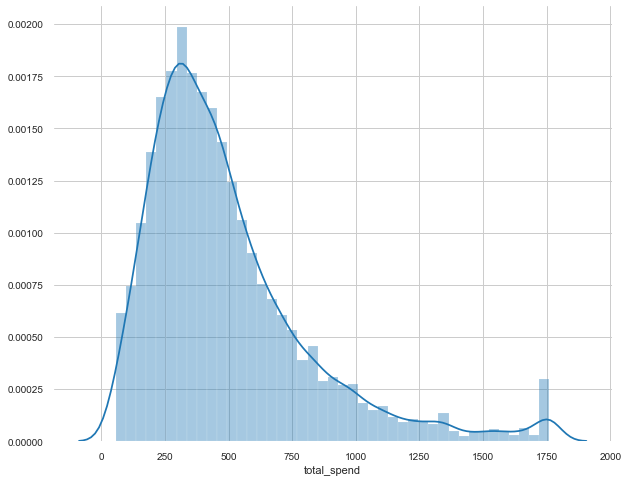

In [88]:
#1, Normality of Y variable
plt.figure(figsize = (10, 8))
sns.distplot(final.total_spend)
plt.show()

In [89]:
final.total_spend.skew()

1.615173337243418

## Now as you can see distribution is right skewed so we need to take log and then plot the graph

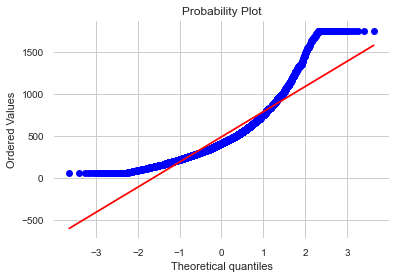

In [90]:
from scipy import stats
import pylab

stats.probplot(final.total_spend, dist="norm", plot=pylab )
pylab.show()
plt.show()
#As we can see above graph our data is not distributed normally perfectly,

# Y variable is not following normal distribution , so we take log of Y variable

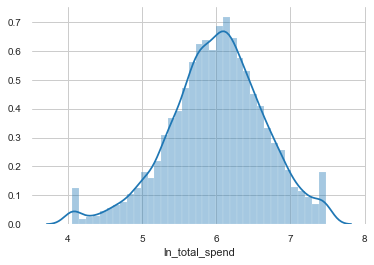

In [91]:
final['ln_total_spend'] = np.log(final.total_spend)

# Distribution of variables
sns.distplot(final['ln_total_spend'])
plt.show()

In [92]:
final.ln_total_spend.skew()

-0.30005358806310334

### we have other transformations as well like: Boxcox technique - It gives the best normality and less skewness of y variable.

In [93]:
# correlation Matrix
corm = final.corr()

In [94]:
corm

,age,ed,income,debtinc,creddebt,othdebt,spoused,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,cardtenure,card2tenure,tenure,longmon,longten,tollmon,tollten,equipmon,equipten,cardmon,cardten,wiremon,wireten,hourstv,total_spend,region_2,region_3,region_4,region_5,townsize_2.0,townsize_3.0,townsize_4.0,townsize_5.0,gender_1,agecat_3,agecat_4,agecat_5,agecat_6,edcat_2,edcat_3,edcat_4,edcat_5,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_1,employ_1,employ_2,employ_3,employ_4,employ_5,employ_6,employ_7,employ_8,employ_9,employ_10,employ_11,employ_12,employ_13,employ_14,employ_15,employ_16,employ_17,employ_18,employ_19,employ_20,employ_21,employ_22,employ_23,employ_24,employ_25,employ_26,employ_27,employ_28,employ_29,employ_30,employ_31,employ_32,employ_33,employ_34,employ_35,employ_36,employ_37,employ_38,employ_39,employ_40,employ_41,employ_42,employ_43,employ_44,employ_45,employ_46,employ_47,employ_48,employ_49,employ_51,employ_52,empcat_2,empcat_3,empcat_4,empcat_5,retire_1,inccat_2,inccat_3,inccat_4,inccat_5,default_1,jobsat_2,jobsat_3,jobsat_4,jobsat_5,marital_1,spousedcat_1,spousedcat_2,spousedcat_3,spousedcat_4,spousedcat_5,homeown_1,hometype_2,hometype_3,hometype_4,address_1,address_2,address_3,address_4,address_5,address_6,address_7,address_8,address_9,address_10,address_11,address_12,address_13,address_14,address_15,address_16,address_17,address_18,address_19,address_20,address_21,address_22,address_23,address_24,address_25,address_26,address_27,address_28,address_29,address_30,address_31,address_32,address_33,address_34,address_35,address_36,address_37,address_38,address_39,address_40,address_41,address_42,address_43,address_44,address_45,address_46,address_47,address_48,address_49,address_50,address_51,address_52,address_53,address_54,address_55,address_57,addresscat_2,addresscat_3,addresscat_4,addresscat_5,cars_1,cars_2,cars_3,cars_4,cars_5,cars_6,cars_7,cars_8,carown_0,carown_1,cartype_0,cartype_1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_0,carbought_1,carbuy_1,commute_2,commute_3,commute_4,commute_5,commute_6,commute_7,commute_8,commute_9,commute_10,commutecat_2,commutecat_3,commutecat_4,commutecat_5,commutecar_1,commutemotorcycle_1,commutecarpool_1,commutebus_1,commuterail_1,commutepublic_1,commutebike_1,commutewalk_1,commutenonmotor_1,telecommute_1,reason_2,reason_3,reason_4,reason_9,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,polparty_1,polcontrib_1,vote_1,card_2,card_3,card_4,card_5,cardtype_2,cardtype_3,cardtype_4,cardbenefit_2,cardbenefit_3,cardbenefit_4,cardfee_1,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2_2,card2_3,card2_4,card2_5,card2type_2,card2type_3,card2type_4,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_1,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,active_1,bfast_2,bfast_3,churn_1,tollfree_1,equip_1,callcard_1,wireless_1,multline_1,voice_1,pager_1,internet_1,internet_2,internet_3,internet_4,callid_1,callwait_1,forward_1,confer_1,ebill_1,owntv_1,ownvcr_1,owndvd_1,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1,ln_total_spend
age,1.000000,-0.093966,0.208286,0.039031,0.142401,0.154514,-0.002796,-0.338338,0.026334,0.015743,0.013091,-0.013373,0.009332,0.002326,-0.003264,0.023500,0.175760,-0.056299,0.734838,0.691549,0.612014,0.468660,0.499278,0.106887,0.263328,-0.104212,0.091553,0.294774,0.463020,-0.025350,0.108722,-0.027318,0.031680,0.001396,0.008554,-0.029300,-0.006444,0.006891,-0.013998,-0.043635,-0.035469,-0.010186,-0.460994,-0.167170,0.313188,0.725136,-0.055472,-0.033052,-0.035074,-0.002109,-0.029513,0.022169,-0.022591,-0.006617,0.049940,0.011206,-0.250028,-0.141651,-0.093065,-0.041238,-0.023353,-0.004204,0.032774,0.011996,0.045717,0.053134,0.095315,0.059418,0.096234,0.099008,0.102184,0.076886,0.080529,0.094245,0.089668,0.093547,0.093165,0.099264,0.092008,0.086569,0.102740,0.101122,0.109751,0

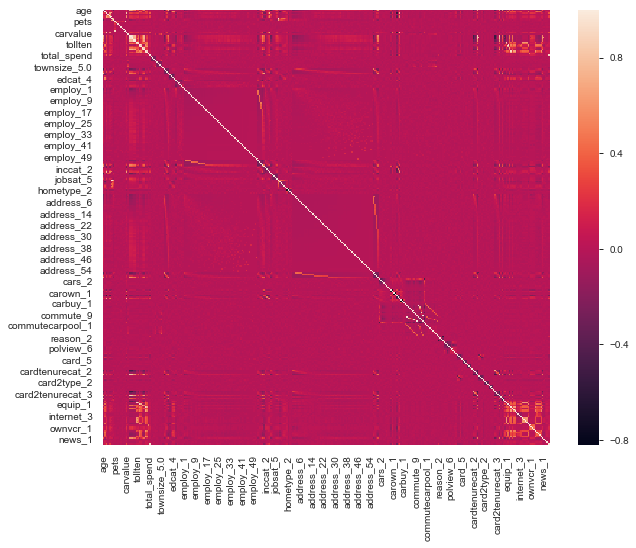

In [95]:
plt.figure(figsize = (10, 8))
sns.heatmap(corm)

In [96]:
#renaming columns as they have 'dot' in the column name

final.rename(columns={'townsize_2.0':'townsize_2','townsize_3.0':'townsize_3','townsize_4.0':'townsize_4','townsize_5.0':'townsize_5'},inplace=True)

In [97]:
corm1 = final.corr() #after renaming variables above

In [98]:
# select those features which have correlation <=0.6 and whichhave more than 0.6, discard them
corm1.to_csv('corm_latest.csv')

In [99]:
final.total_spend

0        149.46
1         77.54
2        359.97
3        359.41
4        507.83
         ...   
4995    1425.67
4996     366.35
4997    1527.75
4998     752.95
4999     407.86
Name: total_spend, Length: 5000, dtype: float64

In [100]:
final.ln_total_spend

0       5.007029
1       4.350794
2       5.886021
3       5.884464
4       6.230147
          ...   
4995    7.262397
4996    5.903589
4997    7.331551
4998    6.623999
4999    6.010924
Name: ln_total_spend, Length: 5000, dtype: float64

In [101]:
final.loc[2430,]['ln_total_spend']

7.473127268157884

In [102]:
final.shape

(5000, 309)

In [103]:
new_df = (final.isna()
            .sum()
            .to_frame('missing_count')
            #.assign(missing_ratio = lambda x: x['missing_count']/len(dd))
            .loc[final.isna().any()] )
print(new_df)

Empty DataFrame
Columns: [missing_count]
Index: []


# F-Regression for Feature Selection

In [104]:
Features = final.columns.difference(['ln_total_spend','total_spend'])

In [105]:
from sklearn.feature_selection import f_regression

In [106]:
# run the F regression to get the significant variables
features = final[Features]
target = final['ln_total_spend']
F_values, p_values  = f_regression( features, target )

In [107]:
# get the results in the datafram
F_Regression_results = pd.concat([pd.Series(features.columns), 
                            pd.Series(F_values), pd.Series(p_values).round(5)], axis = 1)

# add the column names
F_Regression_results.columns = ['Feature', 'F_value', 'p_value']

In [108]:
F_Regression_results

,Feature,F_value,p_value
0,active_1,0.099140,0.75288
1,address_1,10.198180,0.00141
2,address_10,1.060731,0.30310
3,address_11,1.053204,0.30482
4,address_12,0.032960,0.85595
...,...,...,...
302,voice_1,10.132464,0.00147
303,vote_1,15.628862,0.00008
304,wireless_1,27.549440,0.00000
305,wiremon,38.275030,0.00000


In [109]:
F_Regression_results.to_csv('F_Regnew.csv')

In [110]:
#top100=F_Regression_results.sort_values(by  = 'p_value')
#top100[0:100]

In [111]:
# Filter the data where p is <= 0.1
(F_Regression_results.loc[ F_Regression_results.p_value <= 0.05, 'Feature' ])

1       address_1
7      address_15
15     address_22
21     address_28
23      address_3
          ...    
302       voice_1
303        vote_1
304    wireless_1
305       wiremon
306       wireten
Name: Feature, Length: 112, dtype: object

In [112]:
Selected_features_from_freg = list(F_Regression_results.loc[ F_Regression_results.p_value <= 0.05, 'Feature' ])
len(Selected_features_from_freg)

112

In [113]:
print(list(Selected_features_from_freg))

['address_1', 'address_15', 'address_22', 'address_28', 'address_3', 'address_32', 'address_4', 'addresscat_2', 'addresscat_3', 'addresscat_4', 'agecat_4', 'agecat_5', 'agecat_6', 'bfast_2', 'bfast_3', 'callid_1', 'callwait_1', 'carcatvalue_1', 'carcatvalue_2', 'carcatvalue_3', 'card2_2', 'card2_3', 'card2_4', 'card2_5', 'card2benefit_3', 'card2tenure', 'card2tenurecat_2', 'card2tenurecat_4', 'card2tenurecat_5', 'card_2', 'card_3', 'card_4', 'card_5', 'cardten', 'cardtenure', 'cardtenurecat_3', 'cardtenurecat_4', 'cardtenurecat_5', 'carown_0', 'carown_1', 'cars_1', 'carvalue', 'commute_4', 'confer_1', 'creddebt', 'ebill_1', 'ed', 'edcat_2', 'edcat_4', 'edcat_5', 'empcat_4', 'empcat_5', 'employ_1', 'employ_14', 'employ_17', 'employ_24', 'employ_26', 'employ_32', 'equip_1', 'equipmon', 'equipten', 'forward_1', 'gender_1', 'homeown_1', 'hometype_2', 'hometype_3', 'hourstv', 'inccat_2', 'inccat_3', 'inccat_4', 'inccat_5', 'income', 'internet_3', 'internet_4', 'jobcat_2', 'jobcat_3', 'jobsa

In [114]:
final.total_spend.head()

0    149.46
1     77.54
2    359.97
3    359.41
4    507.83
Name: total_spend, dtype: float64

In [115]:
final.ln_total_spend

0       5.007029
1       4.350794
2       5.886021
3       5.884464
4       6.230147
          ...   
4995    7.262397
4996    5.903589
4997    7.331551
4998    6.623999
4999    6.010924
Name: ln_total_spend, Length: 5000, dtype: float64

In [116]:
len(Features)

307

In [117]:
len(Selected_features_from_freg)

112

### Multicollinearity Check

In [118]:
# import the packages for vif - Variance Inflation factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [119]:
formula0='ln_total_spend ~ '+ ' + '.join(Selected_features_from_freg)

In [120]:
formula0

'ln_total_spend ~ address_1 + address_15 + address_22 + address_28 + address_3 + address_32 + address_4 + addresscat_2 + addresscat_3 + addresscat_4 + agecat_4 + agecat_5 + agecat_6 + bfast_2 + bfast_3 + callid_1 + callwait_1 + carcatvalue_1 + carcatvalue_2 + carcatvalue_3 + card2_2 + card2_3 + card2_4 + card2_5 + card2benefit_3 + card2tenure + card2tenurecat_2 + card2tenurecat_4 + card2tenurecat_5 + card_2 + card_3 + card_4 + card_5 + cardten + cardtenure + cardtenurecat_3 + cardtenurecat_4 + cardtenurecat_5 + carown_0 + carown_1 + cars_1 + carvalue + commute_4 + confer_1 + creddebt + ebill_1 + ed + edcat_2 + edcat_4 + edcat_5 + empcat_4 + empcat_5 + employ_1 + employ_14 + employ_17 + employ_24 + employ_26 + employ_32 + equip_1 + equipmon + equipten + forward_1 + gender_1 + homeown_1 + hometype_2 + hometype_3 + hourstv + inccat_2 + inccat_3 + inccat_4 + inccat_5 + income + internet_3 + internet_4 + jobcat_2 + jobcat_3 + jobsat_4 + jobsat_5 + longmon + longten + multline_1 + news_1 + o

In [121]:
formula0= ''' ln_total_spend ~ address_1 + address_15 + address_22 + address_28 + address_3 + address_32 + address_4 + 
addresscat_2 + addresscat_3 + addresscat_4 + agecat_4 + agecat_5 + agecat_6 + bfast_2 + bfast_3 + callid_1 + callwait_1 + 
carcatvalue_1 + carcatvalue_3 + card2_2 + card2_3 + card2_4 + card2_5 + card2benefit_3 +
card2tenurecat_2 + card2tenurecat_4 + card2tenurecat_5 + card_2 + card_3 + card_4 + card_5 + cardten + 
cardtenurecat_3 + cardtenurecat_4 + carown_0 + carown_1 + cars_1 + commute_4 + confer_1 + 
creddebt + ebill_1 + ed + edcat_2 + edcat_4 + edcat_5 + empcat_4 + empcat_5 + employ_1 + employ_14 + employ_17 + employ_24 +
employ_26 + employ_32 + equip_1 + equipten + forward_1 + gender_1 + homeown_1 + hometype_2 + hometype_3 + hourstv +
inccat_2 + inccat_3 + inccat_4 + income + internet_3 + internet_4 + jobcat_2 + jobcat_3 + jobsat_4 + jobsat_5 + 
longmon + multline_1 + news_1 + othdebt + owncd_1 + owndvd_1 + ownfax_1 + owngame_1 + ownipod_1 + ownpc_1 + ownpda_1 +
owntv_1 + ownvcr_1 + pager_1 + polcontrib_1 + polview_6 + reason_2 + reason_4 + region_5 + response_03_1 + retire_1 + spoused +
spousedcat_1 + spousedcat_4 + tollfree_1 + tollten + voice_1 + vote_1 + wireless_1 + wireten '''

In [122]:
# High VIF of the variable means information in that variable has already been explained by 
# other X variables present in the model

# separate the Y and X variables
y, X = dmatrices(formula0, final, return_type = 'dataframe')

In [123]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif['Features'] =X.columns
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif.sort_values(by='VIF Factor',ascending=False)

,Features,VIF Factor
0,Intercept,176.299577
65,income,4.915958
101,wireten,4.738454
13,agecat_6,4.582383
27,card2tenurecat_5,4.515772
...,...,...
88,reason_2,1.030784
57,gender_1,1.029600
90,region_5,1.023826
89,reason_4,1.019416


In [124]:
#VIF Limit taken 5 here

vif1=vif[vif['VIF Factor']>5][['Features','VIF Factor']]
vif1.sort_values(by='VIF Factor',ascending=False)
# remove these one by one

,Features,VIF Factor
0,Intercept,176.299577


In [125]:
len(vif1)

1

In [126]:
len(vif)

102

In [127]:
vif.loc[vif.Features != 'Intercept']

,Features,VIF Factor
1,address_1,1.298020
2,address_15,1.135835
3,address_22,1.091112
4,address_28,1.081414
5,address_3,1.341892
...,...,...
97,tollten,3.421509
98,voice_1,2.173606
99,vote_1,1.056009
100,wireless_1,4.076714


In [128]:
Features = list(vif.loc[ vif.Features != 'Intercept', 'Features'])

In [129]:
len(Features)

101

### Check 3 - All x variables should have a linear relationship with Y

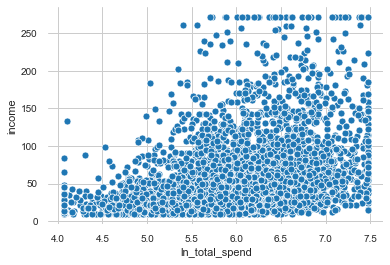

In [130]:
sns.scatterplot(final.ln_total_spend,final.income)

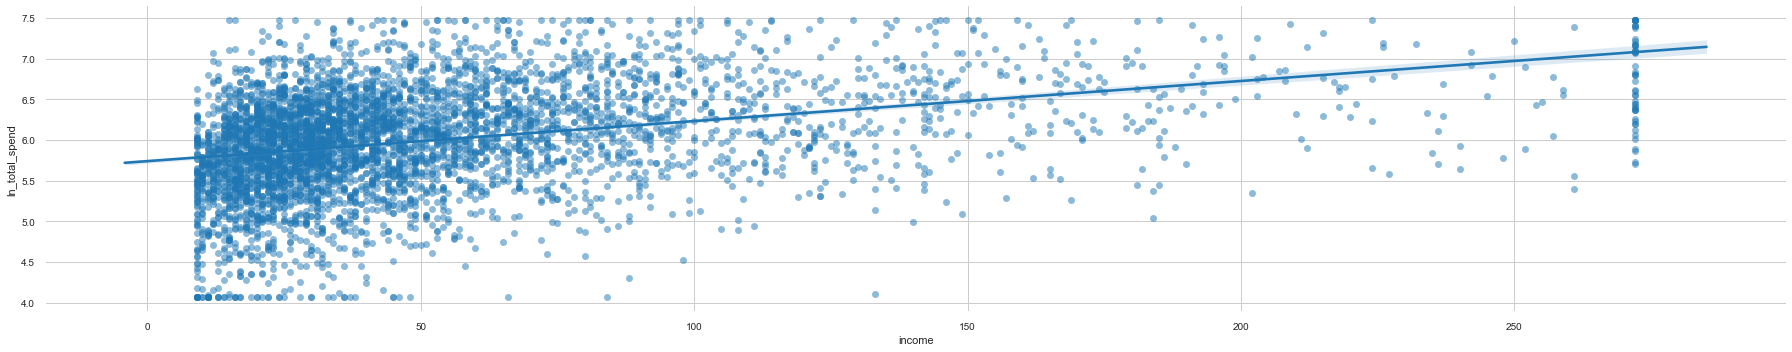

In [131]:
sns.lmplot(x="income",y="ln_total_spend",data=final,aspect=5,scatter_kws={'alpha':0.5})

In [132]:
#sns.pairplot(final, y_vars="ln_total_spend", x_vars=final[Features])

In [133]:
#final=pd.concat([final.ln_total_spend,final[Features]],axis=1)
final[['ln_total_spend','total_spend']]

,ln_total_spend,total_spend
0,5.007029,149.46
1,4.350794,77.54
2,5.886021,359.97
3,5.884464,359.41
4,6.230147,507.83
...,...,...
4995,7.262397,1425.67
4996,5.903589,366.35
4997,7.331551,1527.75
4998,6.623999,752.95


In [134]:
#final=pd.concat([final.])

## Model Building Steps

### 1. split into train and testing

In [135]:
train,test=train_test_split(final,test_size=0.3,random_state=142)
#train_x,test_x,train_y,test_y=train_test_split(final[Features],
#                                              final['ln_total_spend'],
#                                               test_size=.2,
#                                               random_state=123)

In [136]:
train_x,test_x,train_y,test_y=train_test_split(final[Features],
                                            final['ln_total_spend'],
                                              test_size=.3,
                                              random_state=142)

In [137]:
print("no of obs in train",len(train), "|", 'no of obs in test', len(test))

no of obs in train 3500 | no of obs in test 1500


In [138]:
train.head()

,age,ed,income,debtinc,creddebt,othdebt,spoused,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,cardtenure,card2tenure,tenure,longmon,longten,tollmon,tollten,equipmon,equipten,cardmon,cardten,wiremon,wireten,hourstv,total_spend,region_2,region_3,region_4,region_5,townsize_2,townsize_3,townsize_4,townsize_5,gender_1,agecat_3,agecat_4,agecat_5,agecat_6,edcat_2,edcat_3,edcat_4,edcat_5,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_1,employ_1,employ_2,employ_3,employ_4,employ_5,employ_6,employ_7,employ_8,employ_9,employ_10,employ_11,employ_12,employ_13,employ_14,employ_15,employ_16,employ_17,employ_18,employ_19,employ_20,employ_21,employ_22,employ_23,employ_24,employ_25,employ_26,employ_27,employ_28,employ_29,employ_30,employ_31,employ_32,employ_33,employ_34,employ_35,employ_36,employ_37,employ_38,employ_39,employ_40,employ_41,employ_42,employ_43,employ_44,employ_45,employ_46,employ_47,employ_48,employ_49,employ_51,employ_52,empcat_2,empcat_3,empcat_4,empcat_5,retire_1,inccat_2,inccat_3,inccat_4,inccat_5,default_1,jobsat_2,jobsat_3,jobsat_4,jobsat_5,marital_1,spousedcat_1,spousedcat_2,spousedcat_3,spousedcat_4,spousedcat_5,homeown_1,hometype_2,hometype_3,hometype_4,address_1,address_2,address_3,address_4,address_5,address_6,address_7,address_8,address_9,address_10,address_11,address_12,address_13,address_14,address_15,address_16,address_17,address_18,address_19,address_20,address_21,address_22,address_23,address_24,address_25,address_26,address_27,address_28,address_29,address_30,address_31,address_32,address_33,address_34,address_35,address_36,address_37,address_38,address_39,address_40,address_41,address_42,address_43,address_44,address_45,address_46,address_47,address_48,address_49,address_50,address_51,address_52,address_53,address_54,address_55,address_57,addresscat_2,addresscat_3,addresscat_4,addresscat_5,cars_1,cars_2,cars_3,cars_4,cars_5,cars_6,cars_7,cars_8,carown_0,carown_1,cartype_0,cartype_1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_0,carbought_1,carbuy_1,commute_2,commute_3,commute_4,commute_5,commute_6,commute_7,commute_8,commute_9,commute_10,commutecat_2,commutecat_3,commutecat_4,commutecat_5,commutecar_1,commutemotorcycle_1,commutecarpool_1,commutebus_1,commuterail_1,commutepublic_1,commutebike_1,commutewalk_1,commutenonmotor_1,telecommute_1,reason_2,reason_3,reason_4,reason_9,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,polparty_1,polcontrib_1,vote_1,card_2,card_3,card_4,card_5,cardtype_2,cardtype_3,cardtype_4,cardbenefit_2,cardbenefit_3,cardbenefit_4,cardfee_1,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2_2,card2_3,card2_4,card2_5,card2type_2,card2type_3,card2type_4,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_1,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,active_1,bfast_2,bfast_3,churn_1,tollfree_1,equip_1,callcard_1,wireless_1,multline_1,voice_1,pager_1,internet_1,internet_2,internet_3,internet_4,callid_1,callwait_1,forward_1,confer_1,ebill_1,owntv_1,ownvcr_1,owndvd_1,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1,ln_total_spend
3481,36,14,17.0,6.6,0.179520,0.942480,-1,1,8,0,1,0,0,0,0,7,7.1,18.0,7,6,18,4.10,59.25,14.75,220.55,0.0,0.0,25.25,390.0,0.00,0.00,25,254.90,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,1,0,1,1,1,1,0,1,0,1,0,0,0,0,0,5.540871
4330,18,13,19.0,6.0,0.462840,0.677160,-1,1,9,2,0,0,0,0,0,7,8.8,21.0,0,0,11,2.75,28.70,12.00,

In [139]:
final

,age,ed,income,debtinc,creddebt,othdebt,spoused,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,cardtenure,card2tenure,tenure,longmon,longten,tollmon,tollten,equipmon,equipten,cardmon,cardten,wiremon,wireten,hourstv,total_spend,region_2,region_3,region_4,region_5,townsize_2,townsize_3,townsize_4,townsize_5,gender_1,agecat_3,agecat_4,agecat_5,agecat_6,edcat_2,edcat_3,edcat_4,edcat_5,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_1,employ_1,employ_2,employ_3,employ_4,employ_5,employ_6,employ_7,employ_8,employ_9,employ_10,employ_11,employ_12,employ_13,employ_14,employ_15,employ_16,employ_17,employ_18,employ_19,employ_20,employ_21,employ_22,employ_23,employ_24,employ_25,employ_26,employ_27,employ_28,employ_29,employ_30,employ_31,employ_32,employ_33,employ_34,employ_35,employ_36,employ_37,employ_38,employ_39,employ_40,employ_41,employ_42,employ_43,employ_44,employ_45,employ_46,employ_47,employ_48,employ_49,employ_51,employ_52,empcat_2,empcat_3,empcat_4,empcat_5,retire_1,inccat_2,inccat_3,inccat_4,inccat_5,default_1,jobsat_2,jobsat_3,jobsat_4,jobsat_5,marital_1,spousedcat_1,spousedcat_2,spousedcat_3,spousedcat_4,spousedcat_5,homeown_1,hometype_2,hometype_3,hometype_4,address_1,address_2,address_3,address_4,address_5,address_6,address_7,address_8,address_9,address_10,address_11,address_12,address_13,address_14,address_15,address_16,address_17,address_18,address_19,address_20,address_21,address_22,address_23,address_24,address_25,address_26,address_27,address_28,address_29,address_30,address_31,address_32,address_33,address_34,address_35,address_36,address_37,address_38,address_39,address_40,address_41,address_42,address_43,address_44,address_45,address_46,address_47,address_48,address_49,address_50,address_51,address_52,address_53,address_54,address_55,address_57,addresscat_2,addresscat_3,addresscat_4,addresscat_5,cars_1,cars_2,cars_3,cars_4,cars_5,cars_6,cars_7,cars_8,carown_0,carown_1,cartype_0,cartype_1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_0,carbought_1,carbuy_1,commute_2,commute_3,commute_4,commute_5,commute_6,commute_7,commute_8,commute_9,commute_10,commutecat_2,commutecat_3,commutecat_4,commutecat_5,commutecar_1,commutemotorcycle_1,commutecarpool_1,commutebus_1,commuterail_1,commutepublic_1,commutebike_1,commutewalk_1,commutenonmotor_1,telecommute_1,reason_2,reason_3,reason_4,reason_9,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,polparty_1,polcontrib_1,vote_1,card_2,card_3,card_4,card_5,cardtype_2,cardtype_3,cardtype_4,cardbenefit_2,cardbenefit_3,cardbenefit_4,cardfee_1,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2_2,card2_3,card2_4,card2_5,card2type_2,card2type_3,card2type_4,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_1,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,active_1,bfast_2,bfast_3,churn_1,tollfree_1,equip_1,callcard_1,wireless_1,multline_1,voice_1,pager_1,internet_1,internet_2,internet_3,internet_4,callid_1,callwait_1,forward_1,confer_1,ebill_1,owntv_1,ownvcr_1,owndvd_1,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1,ln_total_spend
0,20,15,31.0,11.1,1.200909,2.240091,-1,3,0,0,0,0,0,0,0,0,14.300,22.0,2,3,5,6.50,34.40,29.0,161.05,29.50,126.10,14.25,60.0,0.00,0.00,13,149.46,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,1,1,1,0,1,1,1,0,0,0,0,0,1,1,1,0,1,1,1,0,0,0,1,1,0,0,0,1,0,5.007029
1,22,17,15.0,18.6,1.222020,1.567980,-1,2,6,0,0,0,0,0,0,6,6.800,29.0,4,4,39,8.90,330.60,0.

### 2. Building Linear Regression Model

In [140]:
formula1='ln_total_spend ~ '+ ' + '.join(Features)

In [141]:
formula1

'ln_total_spend ~ address_1 + address_15 + address_22 + address_28 + address_3 + address_32 + address_4 + addresscat_2 + addresscat_3 + addresscat_4 + agecat_4 + agecat_5 + agecat_6 + bfast_2 + bfast_3 + callid_1 + callwait_1 + carcatvalue_1 + carcatvalue_3 + card2_2 + card2_3 + card2_4 + card2_5 + card2benefit_3 + card2tenurecat_2 + card2tenurecat_4 + card2tenurecat_5 + card_2 + card_3 + card_4 + card_5 + cardten + cardtenurecat_3 + cardtenurecat_4 + carown_0 + carown_1 + cars_1 + commute_4 + confer_1 + creddebt + ebill_1 + ed + edcat_2 + edcat_4 + edcat_5 + empcat_4 + empcat_5 + employ_1 + employ_14 + employ_17 + employ_24 + employ_26 + employ_32 + equip_1 + equipten + forward_1 + gender_1 + homeown_1 + hometype_2 + hometype_3 + hourstv + inccat_2 + inccat_3 + inccat_4 + income + internet_3 + internet_4 + jobcat_2 + jobcat_3 + jobsat_4 + jobsat_5 + longmon + multline_1 + news_1 + othdebt + owncd_1 + owndvd_1 + ownfax_1 + owngame_1 + ownipod_1 + ownpc_1 + ownpda_1 + owntv_1 + ownvcr_1

In [142]:
formula1=''' ln_total_spend ~  address_32 + card2_2 +
card2_3 + card2_4 + card2_5 + card2benefit_3 + card_2 + card_3 + card_4 + card_5 + 
 employ_17
+ employ_26 + employ_32 + gender_1 + inccat_2 + inccat_3 + inccat_4 + income   + 
 reason_2  + retire_1  '''

In [143]:
lm=sm.ols(formula1,train).fit()
summ=lm.summary()
summ

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         ln_total_spend   R-squared:                       0.340
Model:                            OLS   Adj. R-squared:                  0.336
Method:                 Least Squares   F-statistic:                     89.51
Date:                Mon, 13 Jul 2020   Prob (F-statistic):          6.03e-295
Time:                        14:17:40   Log-Likelihood:                -2707.0
No. Observations:                3500   AIC:                             5456.
Df Residuals:                    3479   BIC:                             5585.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.5756      0.041    159.756      0.000       6.495       6.656
address_32         0.1935      0.078      2.469      0.014       0.040       0.347
card2_2           -0.4152      0.029    -14.116      0.000      -0.473      -0.358
card2_3           -0.4018      0.029    -13.737      0.000      -0.459      -0.344
card2_4           -0.4592      0.032    -14.424      0.000      -0.522      -0.397
card2_5           -0.3356      0.042     -7.977      0.000      -0.418      -0.253
card2benefit_3    -0.0522      0.020     -2.571      0.010      -0.092      -0.012
card_2            -0.5828      0.028    -20.617      0.000      -0.638      -0.527
card_3            -0.6188      0.029    -21.432      0.000      -0.675      -0.562
card_4            -0.6965      0.030    -23.567      0.000      -0.754      -0.639
card_5            -0.5195      0.049    -10.556      0.000      -0.616      -0.423
employ_17          0.0819      0.065      1.262      0.207      -0.045       0.209
employ_26          0.1354      0.109      1.243      0.214      -0.078       0.349
employ_32          0.2687      0.147      1.827      0.068      -0.020       0.557
gender_1          -0.0688      0.018     -3.838      0.000      -0.104      -0.034
inccat_2           0.1221      0.023      5.342      0.000       0.077       0.167
inccat_3           0.2133      0.028      7.700      0.000       0.159       0.268
inccat_4           0.2045      0.031      6.633      0.000       0.144       0.265
income             0.0040      0.000     17.813      0.000       0.004       0.004
reason_2           0.2550      0.035      7.318      0.000       0.187       0.323
retire_1          -0.1248      0.028     -4.464      0.000      -0.180      -0.070
==============================================================================
Omnibus:                       77.878   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               82.985
Skew:                          -0.361   Prob(JB):                     9.55e-19
Kurtosis:                       3.219   Cond. No.                     1.17e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [144]:
lm.params

Intercept         6.575602
address_32        0.193479
card2_2          -0.415216
card2_3          -0.401768
card2_4          -0.459236
card2_5          -0.335611
card2benefit_3   -0.052198
card_2           -0.582813
card_3           -0.618833
card_4           -0.696535
card_5           -0.519480
employ_17         0.081916
employ_26         0.135350
employ_32         0.268744
gender_1         -0.068817
inccat_2          0.122107
inccat_3          0.213317
inccat_4          0.204505
income            0.004009
reason_2          0.254991
retire_1         -0.124789
dtype: float64

### Driving Factors

In [145]:
lm.pvalues.sort_values(ascending=False)

employ_26          2.138554e-01
employ_17          2.069107e-01
employ_32          6.781016e-02
address_32         1.361541e-02
card2benefit_3     1.016713e-02
gender_1           1.260390e-04
retire_1           8.308185e-06
inccat_2           9.792310e-08
inccat_4           3.787959e-11
reason_2           3.110707e-13
inccat_3           1.755907e-14
card2_5            2.015839e-15
card_5             1.157523e-25
card2_3            7.383299e-42
card2_2            4.847852e-44
card2_4            7.494572e-46
income             5.399414e-68
card_2             3.361453e-89
card_3             8.159299e-96
card_4            4.687652e-114
Intercept          0.000000e+00
dtype: float64

In [146]:
print('R2: ', lm.rsquared) # Find the r**2

R2:  0.33975243815312395


### Predict 

In [147]:
# Step 4: predict the sales on the training data
train.loc[:, 'pred_sales'] = np.exp( lm.predict(train) )

C:\Users\Himanshu\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Himanshu\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [148]:
# Step 4: predict the sales on the training data
test.loc[:, 'pred_sales'] = np.exp( lm.predict(test) )

In [149]:
test.head()

,age,ed,income,debtinc,creddebt,othdebt,spoused,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,cardtenure,card2tenure,tenure,longmon,longten,tollmon,tollten,equipmon,equipten,cardmon,cardten,wiremon,wireten,hourstv,total_spend,region_2,region_3,region_4,region_5,townsize_2,townsize_3,townsize_4,townsize_5,gender_1,agecat_3,agecat_4,agecat_5,agecat_6,edcat_2,edcat_3,edcat_4,edcat_5,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_1,employ_1,employ_2,employ_3,employ_4,employ_5,employ_6,employ_7,employ_8,employ_9,employ_10,employ_11,employ_12,employ_13,employ_14,employ_15,employ_16,employ_17,employ_18,employ_19,employ_20,employ_21,employ_22,employ_23,employ_24,employ_25,employ_26,employ_27,employ_28,employ_29,employ_30,employ_31,employ_32,employ_33,employ_34,employ_35,employ_36,employ_37,employ_38,employ_39,employ_40,employ_41,employ_42,employ_43,employ_44,employ_45,employ_46,employ_47,employ_48,employ_49,employ_51,employ_52,empcat_2,empcat_3,empcat_4,empcat_5,retire_1,inccat_2,inccat_3,inccat_4,inccat_5,default_1,jobsat_2,jobsat_3,jobsat_4,jobsat_5,marital_1,spousedcat_1,spousedcat_2,spousedcat_3,spousedcat_4,spousedcat_5,homeown_1,hometype_2,hometype_3,hometype_4,address_1,address_2,address_3,address_4,address_5,address_6,address_7,address_8,address_9,address_10,address_11,address_12,address_13,address_14,address_15,address_16,address_17,address_18,address_19,address_20,address_21,address_22,address_23,address_24,address_25,address_26,address_27,address_28,address_29,address_30,address_31,address_32,address_33,address_34,address_35,address_36,address_37,address_38,address_39,address_40,address_41,address_42,address_43,address_44,address_45,address_46,address_47,address_48,address_49,address_50,address_51,address_52,address_53,address_54,address_55,address_57,addresscat_2,addresscat_3,addresscat_4,addresscat_5,cars_1,cars_2,cars_3,cars_4,cars_5,cars_6,cars_7,cars_8,carown_0,carown_1,cartype_0,cartype_1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_0,carbought_1,carbuy_1,commute_2,commute_3,commute_4,commute_5,commute_6,commute_7,commute_8,commute_9,commute_10,commutecat_2,commutecat_3,commutecat_4,commutecat_5,commutecar_1,commutemotorcycle_1,commutecarpool_1,commutebus_1,commuterail_1,commutepublic_1,commutebike_1,commutewalk_1,commutenonmotor_1,telecommute_1,reason_2,reason_3,reason_4,reason_9,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,polparty_1,polcontrib_1,vote_1,card_2,card_3,card_4,card_5,cardtype_2,cardtype_3,cardtype_4,cardbenefit_2,cardbenefit_3,cardbenefit_4,cardfee_1,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2_2,card2_3,card2_4,card2_5,card2type_2,card2type_3,card2type_4,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_1,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,active_1,bfast_2,bfast_3,churn_1,tollfree_1,equip_1,callcard_1,wireless_1,multline_1,voice_1,pager_1,internet_1,internet_2,internet_3,internet_4,callid_1,callwait_1,forward_1,confer_1,ebill_1,owntv_1,ownvcr_1,owndvd_1,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1,ln_total_spend,pred_sales
1894,79,14,14.0,5.7,0.252966,0.545034,11,2,7,0,0,0,2,0,0,5,4.5,16.0,29,20,46,13.25,691.40,0.00,0.00,38.85,1730.15,32.75,1460.0,0.0,0.0,19,270.36,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,0,1,0,0,0,5.599754,241.288666
4196,33,14,23.0,2.9,0.311489,0.355511,15,5,0,0,0,0,0,0,0,0,12.3,

In [150]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [151]:
# a) accuracy metrics (a. MAE: Mean Absolute Error)
MAE_train = mean_absolute_error(train.total_spend, train.pred_sales)
MAE_test = mean_absolute_error(test.total_spend, test.pred_sales)

# print the values of MAE for train and test
print('MAE of training data: ', MAE_train,  ' | ', 'MAE of testing data: ', MAE_test)

MAE of training data:  187.13909605652015  |  MAE of testing data:  189.74111909583797


In [152]:
# Step 6: 
# b) accuracy metrics (a. MAPE: Mean Absolute Percentage Error)
MAPE_train = np.mean(np.abs(train['total_spend'] - train['pred_sales'])/train['total_spend'])
MAPE_test = np.mean(np.abs(test['total_spend'] - test['pred_sales'])/test['total_spend'])

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  0.47302446708975876  |  MAPE of testing data:  0.4743279050543598


In [153]:
# Step 6: 
# c) MSE: Mean squared Error and RMSE: Root Mean Square Error
MSE_train = mean_squared_error(train.total_spend, train.pred_sales)
MSE_test = mean_squared_error(test.total_spend, test.pred_sales)

# print the values of MSE for train and test
print('MSE of training data: ', MSE_train,  ' | ', 'MSE of testing data: ', MSE_test)

# print the values of RMSE for train and test
print('RMSE of training data: ', np.sqrt(MSE_train),  ' | ', 'RMSE of testing data: ', np.sqrt(MSE_test))

MSE of training data:  71763.96880794608  |  MSE of testing data:  73430.58083600784
RMSE of training data:  267.88797809522185  |  RMSE of testing data:  270.9807757683335


In [154]:
# Step 6: 
# d.1) Corelation between actual and predicted
Corr_train = stats.pearsonr(train.total_spend, train.pred_sales)
Corr_test = stats.pearsonr(test.total_spend, test.pred_sales)

# print the values of Corelation for train and test
print('Corr of training data: ', Corr_train,  ' | ', 'Corr of testing data: ', Corr_test)

Corr of training data:  (0.5860977376285282, 4.94e-322)  |  Corr of testing data:  (0.5709758129359195, 1.6470353575894518e-130)


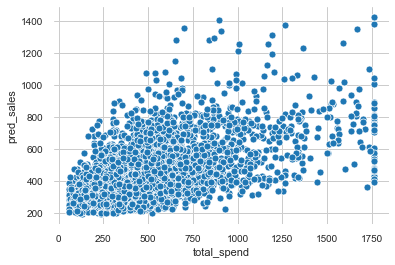

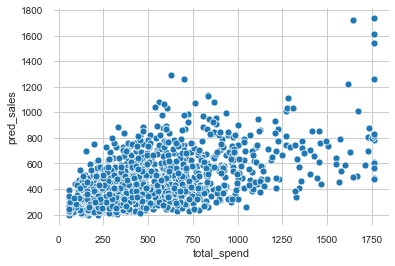

In [155]:
# Step 6: 
# d.2) Corelation between actual and predicted
sns.scatterplot(train.total_spend, train.pred_sales)
plt.show()

sns.scatterplot(test.total_spend, test.pred_sales)
plt.show()

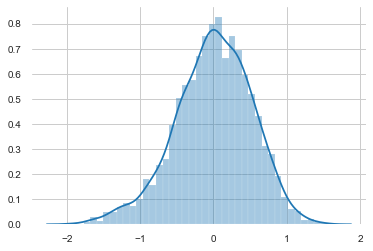

In [156]:
# assumption: Normality of the residuals/error (using distplot)
sns.distplot(lm.resid)
plt.show()

In [157]:
# assumption: mean of residuals/errors is zero
print(lm.resid.mean())

6.351744527169753e-16


In [158]:
# assumption: residuals/errors of the model should not be correlated with dependant (Y) variable
print(stats.stats.pearsonr(lm.resid, train.ln_total_spend))

(0.8125561899628087, 0.0)


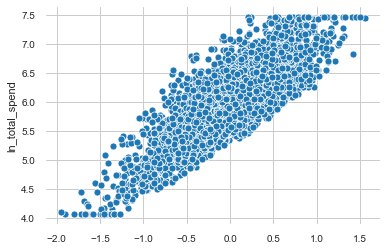

In [159]:
# assumption: homoscedasticity of residuals/errors
sns.scatterplot(lm.resid, train.ln_total_spend)
plt.show()

#### R2 is not so high (0.34), so we will use another modelling technique i.e DECISION TREE

## Decision Tree

In [160]:
from sklearn.tree import DecisionTreeRegressor

In [161]:
import sklearn.tree as dt

from sklearn import metrics
from sklearn.tree import export_graphviz, export
from sklearn.model_selection  import GridSearchCV

In [162]:
DecisionTreeRegressor?

In [163]:
param_grid = {'max_depth': np.arange(1, 16),
             'max_features': np.arange(2,40)}

In [164]:
reg_tree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv = 10)
reg_tree.fit( train_x, train_y )

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeRegressor(criterion='mse', max_depth=None,
                                             max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort=False, random_state=None,
                                             splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
                         'max_features': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 

In [165]:
reg_tree.best_params_

{'max_depth': 5, 'max_features': 34}

In [166]:
reg_tree.best_score_

0.15522960433343427

In [167]:
reg_tree1 = DecisionTreeRegressor( max_depth = 5,max_features= 34 )
reg_tree1.fit( train_x, train_y )

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=34,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [168]:
dir(reg_tree1)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_estimator_type',
 '_get_param_names',
 '_get_tags',
 '_more_tags',
 '_validate_X_predict',
 'apply',
 'class_weight',
 'classes_',
 'criterion',
 'decision_path',
 'feature_importances_',
 'fit',
 'get_depth',
 'get_n_leaves',
 'get_params',
 'max_depth',
 'max_features',
 'max_features_',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'min_samples_leaf',
 'min_samples_split',
 'min_weight_fraction_leaf',
 'n_classes_',
 'n_features_',
 'n_outputs_',
 'predict',
 'presort',
 'random_state',
 'score',
 'set_params',
 'splitter',

In [169]:
reg_tree1.feature_importances_
list(zip(train_x.columns,reg_tree1.feature_importances_ ))

[('address_1', 0.0),
 ('address_15', 0.0),
 ('address_22', 0.0),
 ('address_28', 0.0),
 ('address_3', 0.007392487333374972),
 ('address_32', 0.0),
 ('address_4', 0.0),
 ('addresscat_2', 0.0),
 ('addresscat_3', 0.0),
 ('addresscat_4', 0.0),
 ('agecat_4', 0.0),
 ('agecat_5', 0.0),
 ('agecat_6', 0.0),
 ('bfast_2', 0.0),
 ('bfast_3', 0.0),
 ('callid_1', 0.0),
 ('callwait_1', 0.0),
 ('carcatvalue_1', 0.4227311301482856),
 ('carcatvalue_3', 0.0),
 ('card2_2', 0.012140829206537524),
 ('card2_3', 0.0),
 ('card2_4', 0.0),
 ('card2_5', 0.0),
 ('card2benefit_3', 0.0),
 ('card2tenurecat_2', 0.0),
 ('card2tenurecat_4', 0.0),
 ('card2tenurecat_5', 0.0),
 ('card_2', 0.024280217798859152),
 ('card_3', 0.0161709631778109),
 ('card_4', 0.010251081476216282),
 ('card_5', 0.0),
 ('cardten', 0.011674242806430552),
 ('cardtenurecat_3', 0.0),
 ('cardtenurecat_4', 0.0),
 ('carown_0', 0.02878543807626348),
 ('carown_1', 0.0),
 ('cars_1', 0.0),
 ('commute_4', 0.0),
 ('confer_1', 0.0),
 ('creddebt', 0.0086254543

In [170]:
train_y

3481    5.540871
4330    6.866266
949     5.921712
2606    6.544674
1302    6.396563
          ...   
443     6.161819
2187    5.877344
1616    6.263170
4607    6.456079
277     5.568306
Name: ln_total_spend, Length: 3500, dtype: float64

In [171]:
train_x_predict=reg_tree1.predict(train_x)
train_x_predict

array([5.76953964, 5.7557706 , 6.23659369, ..., 6.23659369, 6.37862607,
       5.76953964])

In [172]:
train.head(6)

,age,ed,income,debtinc,creddebt,othdebt,spoused,reside,pets,pets_cats,pets_dogs,pets_birds,pets_reptiles,pets_small,pets_saltfish,pets_freshfish,carvalue,commutetime,cardtenure,card2tenure,tenure,longmon,longten,tollmon,tollten,equipmon,equipten,cardmon,cardten,wiremon,wireten,hourstv,total_spend,region_2,region_3,region_4,region_5,townsize_2,townsize_3,townsize_4,townsize_5,gender_1,agecat_3,agecat_4,agecat_5,agecat_6,edcat_2,edcat_3,edcat_4,edcat_5,jobcat_2,jobcat_3,jobcat_4,jobcat_5,jobcat_6,union_1,employ_1,employ_2,employ_3,employ_4,employ_5,employ_6,employ_7,employ_8,employ_9,employ_10,employ_11,employ_12,employ_13,employ_14,employ_15,employ_16,employ_17,employ_18,employ_19,employ_20,employ_21,employ_22,employ_23,employ_24,employ_25,employ_26,employ_27,employ_28,employ_29,employ_30,employ_31,employ_32,employ_33,employ_34,employ_35,employ_36,employ_37,employ_38,employ_39,employ_40,employ_41,employ_42,employ_43,employ_44,employ_45,employ_46,employ_47,employ_48,employ_49,employ_51,employ_52,empcat_2,empcat_3,empcat_4,empcat_5,retire_1,inccat_2,inccat_3,inccat_4,inccat_5,default_1,jobsat_2,jobsat_3,jobsat_4,jobsat_5,marital_1,spousedcat_1,spousedcat_2,spousedcat_3,spousedcat_4,spousedcat_5,homeown_1,hometype_2,hometype_3,hometype_4,address_1,address_2,address_3,address_4,address_5,address_6,address_7,address_8,address_9,address_10,address_11,address_12,address_13,address_14,address_15,address_16,address_17,address_18,address_19,address_20,address_21,address_22,address_23,address_24,address_25,address_26,address_27,address_28,address_29,address_30,address_31,address_32,address_33,address_34,address_35,address_36,address_37,address_38,address_39,address_40,address_41,address_42,address_43,address_44,address_45,address_46,address_47,address_48,address_49,address_50,address_51,address_52,address_53,address_54,address_55,address_57,addresscat_2,addresscat_3,addresscat_4,addresscat_5,cars_1,cars_2,cars_3,cars_4,cars_5,cars_6,cars_7,cars_8,carown_0,carown_1,cartype_0,cartype_1,carcatvalue_1,carcatvalue_2,carcatvalue_3,carbought_0,carbought_1,carbuy_1,commute_2,commute_3,commute_4,commute_5,commute_6,commute_7,commute_8,commute_9,commute_10,commutecat_2,commutecat_3,commutecat_4,commutecat_5,commutecar_1,commutemotorcycle_1,commutecarpool_1,commutebus_1,commuterail_1,commutepublic_1,commutebike_1,commutewalk_1,commutenonmotor_1,telecommute_1,reason_2,reason_3,reason_4,reason_9,polview_2,polview_3,polview_4,polview_5,polview_6,polview_7,polparty_1,polcontrib_1,vote_1,card_2,card_3,card_4,card_5,cardtype_2,cardtype_3,cardtype_4,cardbenefit_2,cardbenefit_3,cardbenefit_4,cardfee_1,cardtenurecat_2,cardtenurecat_3,cardtenurecat_4,cardtenurecat_5,card2_2,card2_3,card2_4,card2_5,card2type_2,card2type_3,card2type_4,card2benefit_2,card2benefit_3,card2benefit_4,card2fee_1,card2tenurecat_2,card2tenurecat_3,card2tenurecat_4,card2tenurecat_5,active_1,bfast_2,bfast_3,churn_1,tollfree_1,equip_1,callcard_1,wireless_1,multline_1,voice_1,pager_1,internet_1,internet_2,internet_3,internet_4,callid_1,callwait_1,forward_1,confer_1,ebill_1,owntv_1,ownvcr_1,owndvd_1,owncd_1,ownpda_1,ownpc_1,ownipod_1,owngame_1,ownfax_1,news_1,response_01_1,response_02_1,response_03_1,ln_total_spend,pred_sales
3481,36,14,17.0,6.6,0.179520,0.942480,-1,1,8,0,1,0,0,0,0,7,7.1,18.0,7,6,18,4.10,59.25,14.75,220.55,0.0,0.0,25.25,390.0,0.00,0.00,25,254.90,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,1,0,1,1,1,1,0,1,0,1,0,0,0,0,0,5.540871,235.849476
4330,18,13,19.0,6.0,0.462840,0.677160,-1,1,9,2,0,0,0,0,0,7,8.8,21.0,0,

In [173]:
train_x.head(6)

,address_1,address_15,address_22,address_28,address_3,address_32,address_4,addresscat_2,addresscat_3,addresscat_4,agecat_4,agecat_5,agecat_6,bfast_2,bfast_3,callid_1,callwait_1,carcatvalue_1,carcatvalue_3,card2_2,card2_3,card2_4,card2_5,card2benefit_3,card2tenurecat_2,card2tenurecat_4,card2tenurecat_5,card_2,card_3,card_4,card_5,cardten,cardtenurecat_3,cardtenurecat_4,carown_0,carown_1,cars_1,commute_4,confer_1,creddebt,ebill_1,ed,edcat_2,edcat_4,edcat_5,empcat_4,empcat_5,employ_1,employ_14,employ_17,employ_24,employ_26,employ_32,equip_1,equipten,forward_1,gender_1,homeown_1,hometype_2,hometype_3,hourstv,inccat_2,inccat_3,inccat_4,income,internet_3,internet_4,jobcat_2,jobcat_3,jobsat_4,jobsat_5,longmon,multline_1,news_1,othdebt,owncd_1,owndvd_1,ownfax_1,owngame_1,ownipod_1,ownpc_1,ownpda_1,owntv_1,ownvcr_1,pager_1,polcontrib_1,polview_6,reason_2,reason_4,region_5,response_03_1,retire_1,spoused,spousedcat_1,spousedcat_4,tollfree_1,tollten,voice_1,vote_1,wireless_1,wireten
3481,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,1,0,390.0,1,0,0,1,0,0,1,0.179520,0,14,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1,1,1,0,0,25,0,0,0,17.0,0,0,1,0,0,0,4.10,0,0,0.942480,1,1,0,1,0,1,0,1,1,1,1,1,0,0,0,0,0,-1,0,0,1,220.55,0,0,0,0.00
4330,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,1,0,1,0.462840,0,13,1,0,0,0,0,0,0,0,0,0,0,0,0.0,1,0,0,1,0,26,0,0,0,19.0,0,0,0,0,0,0,2.75,0,1,0.677160,1,0,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,-1,0,0,1,128.90,0,0,0,0.00
949,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1985.0,0,0,0,1,0,0,1,0.741120,0,13,1,0,0,0,1,0,0,0,0,0,0,0,0.0,1,1,1,0,0,22,0,1,0,64.0,1,0,0,1,0,0,44.15,1,1,3.098880,1,1,1,1,0,1,0,1,1,1,0,0,0,0,0,0,0,12,0,0,1,2367.25,1,0,0,0.00
2606,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,1525.0,0,0,0,1,1,1,1,1.286908,1,17,0,1,0,0,1,0,0,0,0,0,0,0,0.0,1,1,1,0,0,25,0,0,0,133.0,0,0,0,1,0,0,47.95,1,1,4.166092,1,1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,17,0,1,1,2690.60,1,0,1,2782.05
1302,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0.0,0,1,0,1,0,0,1,0.145299,0,21,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0,1,1,0,1,12,0,0,1,77.0,0,0,1,0,0,0,9.25,0,1,8.401701,1,1,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,17,0,1,0,0.00,0,1,0,0.00
1233,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0.0,0,0,0,1,1,0,0,0.108284,1,18,0,1,0,0,0,0,0,0,0,0,0,0,0.0,0,0,1,0,0,18,0,0,0,22.0,0,0,0,0,0,0,3.00,0,0,2.245716,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,12,0,0,0,0.00,0,1,0,0.00


In [174]:
train_y.head(6)

3481    5.540871
4330    6.866266
949     5.921712
2606    6.544674
1302    6.396563
1233    5.623656
Name: ln_total_spend, dtype: float64

In [175]:
tree_train_pred = pd.DataFrame( { 'actual':np.exp(train_y),
                            'predicted': np.exp(train_x_predict) } )

In [176]:
tree_train_pred

,actual,predicted
3481,254.90,320.390205
4330,959.36,316.008970
949,373.05,511.114530
2606,695.53,511.114530
1302,599.78,511.114530
...,...,...
443,474.29,410.241723
2187,356.86,410.241723
1616,524.88,511.114530
4607,636.56,589.117747


In [177]:
test_x_predict=reg_tree1.predict(test_x)
test_x_predict

array([5.727294  , 5.64958433, 5.7557706 , ..., 5.7557706 , 6.23659369,
       5.64958433])

In [178]:
tree_test_pred = pd.DataFrame( { 'actual':  np.exp(test_y),
                            'predicted': np.exp(reg_tree1.predict( test_x)) } )

In [179]:
tree_test_pred

,actual,predicted
1894,270.36,307.137029
4196,1026.52,284.173318
3690,338.93,316.008970
3330,445.22,284.173318
2633,459.28,410.241723
...,...,...
1541,445.87,511.114530
3517,366.69,316.008970
219,740.55,316.008970
4153,544.74,511.114530


In [ ]:
np.exp

In [181]:
acc=round(reg_tree1.score(train_x,train_y)*100,2)
acc

21.21

In [182]:
acc=round(reg_tree1.score(test_x,test_y)*100,2)
acc

15.45

In [183]:
MAE_tree_train = mean_absolute_error((tree_train_pred.actual),(tree_train_pred.predicted))
MAE_tree_test = mean_absolute_error((tree_test_pred.actual),(tree_test_pred.predicted))


# print the values of MAE for train and test
print('MAE of training data: ', MAE_tree_train,  ' | ', 'MAE of testing data: ', MAE_tree_test)

MAE of training data:  203.29802442838258  |  MAE of testing data:  211.79151645414686


In [184]:
# Step 6: 
#  MSE: Mean squared Error and RMSE: Root Mean Square Error
MSE_tree_train = mean_squared_error(tree_train_pred.actual,tree_train_pred.predicted)
MSE_tree_test = mean_squared_error(tree_test_pred.actual,tree_test_pred.predicted)

# print the values of MSE for train and test
print('MSE of training data: ', MSE_tree_train,  ' | ', 'MSE of testing data: ', MSE_tree_test)

# print the values of RMSE for train and test
print('RMSE of training data: ', np.sqrt(MSE_tree_train),  ' | ', 'RMSE of testing data: ', np.sqrt(MSE_tree_test))

MSE of training data:  87336.37431292847  |  MSE of testing data:  92900.39812773593
RMSE of training data:  295.5272818420128  |  RMSE of testing data:  304.795666189229


In [185]:
import os
os.environ["Path"]+=os.pathsep + 'C:\Program Files (x86)\Graphviz2.38\bin'


In [186]:
export_graphviz( reg_tree1,
              out_file = "spend_tree.odt",
              feature_names = train_x.columns )

In [187]:
import pydotplus as pdot

In [188]:
spend_tree_graph = pdot.graphviz.graph_from_dot_file( 'spend_tree.odt' )

In [189]:
spend_tree_graph

In [190]:
spend_tree_graph.write_jpg( 'spend_tree.jpg' )

True

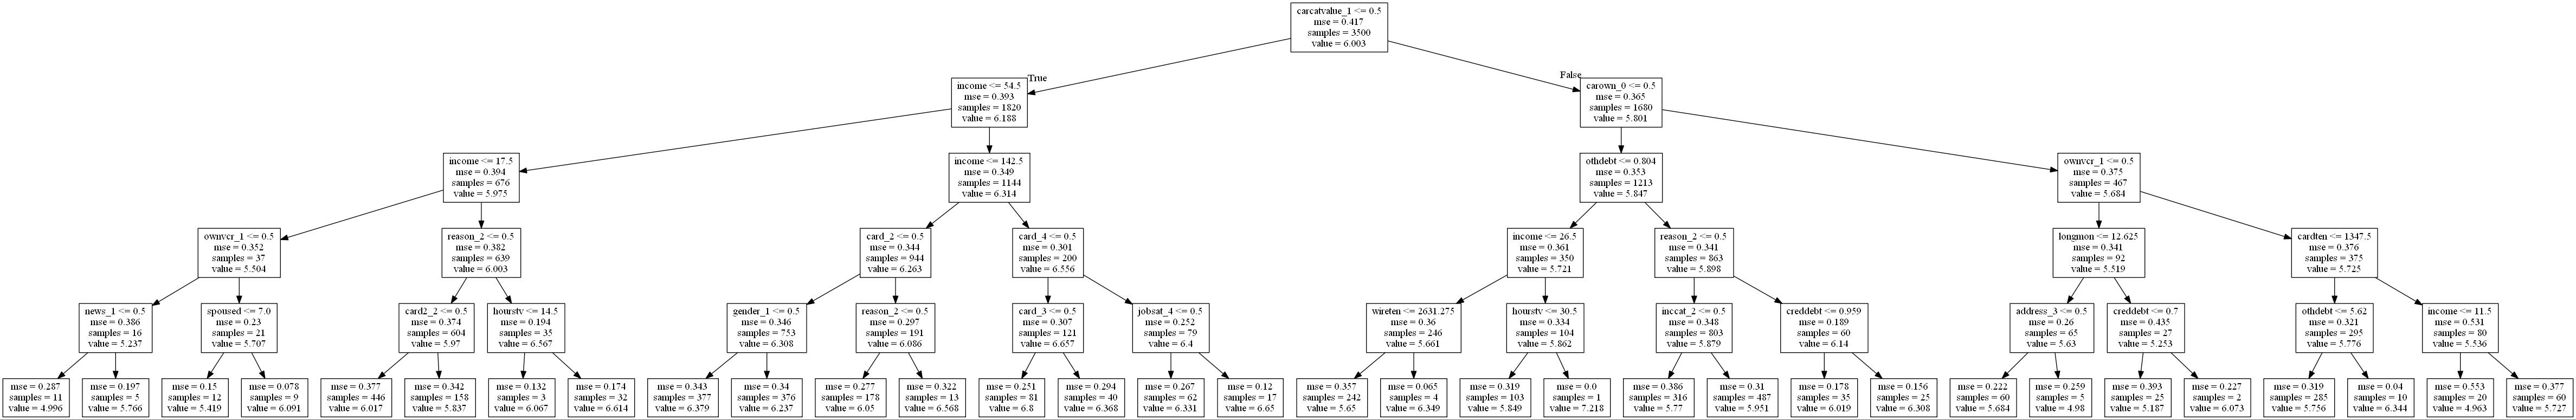

In [191]:
from IPython.display import Image
Image(filename='spend_tree.jpg')

### According to Decision Tree, the key drivers are :

- income
- agecat_6
- reason_2
- owndvd_1
- inccat_3
- card_3
- card_2
- creddebt
- inccat_2
- cardten
- internet_4


## Now, building Random Forest Model

In [192]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection  import GridSearchCV

In [193]:
RandomForestRegressor?

In [194]:
param_grid = { 
    'n_estimators': [50,100,200],
    'max_depth': np.arange(3,8),
    'max_features': np.arange(3,15),
    'n_jobs':[-1]
}

rf_tree = GridSearchCV(RandomForestRegressor(), param_grid, cv = 10)
rf_tree.fit(train_x, train_y)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': array([3, 4, 5, 6

In [195]:
rf_tree.best_params_

{'max_depth': 7, 'max_features': 14, 'n_estimators': 200, 'n_jobs': -1}

In [203]:
rand_reg=RandomForestRegressor(oob_score=True,n_estimators=200,max_depth=7,max_features=14,n_jobs=-1)
rand_reg.fit(train_x,train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
                      max_features=14, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
                      oob_score=True, random_state=None, verbose=0,
                      warm_start=False)

In [204]:
train_y

3481    5.540871
4330    6.866266
949     5.921712
2606    6.544674
1302    6.396563
          ...   
443     6.161819
2187    5.877344
1616    6.263170
4607    6.456079
277     5.568306
Name: ln_total_spend, Length: 3500, dtype: float64

In [205]:
rftree_train_pred = pd.DataFrame( { 'actual':  np.exp(train_y),
                            'predicted': np.exp(rand_reg.predict( train_x)) } )

In [206]:
rftree_train_pred

,actual,predicted
3481,254.90,323.275682
4330,959.36,344.756898
949,373.05,476.168510
2606,695.53,528.021558
1302,599.78,525.250116
...,...,...
443,474.29,373.589889
2187,356.86,444.721834
1616,524.88,481.956985
4607,636.56,537.044916


In [207]:
rftree_test_pred = pd.DataFrame( { 'actual':  np.exp(test_y),
                            'predicted': np.exp(rand_reg.predict( test_x)) } )

In [208]:
rftree_test_pred

,actual,predicted
1894,270.36,264.065040
4196,1026.52,334.638857
3690,338.93,276.345950
3330,445.22,330.088883
2633,459.28,459.890920
...,...,...
1541,445.87,489.846572
3517,366.69,332.888946
219,740.55,346.069069
4153,544.74,477.889600


In [209]:
MAE_rftree_train = mean_absolute_error(rftree_train_pred.actual,rftree_train_pred.predicted)
MAE_rftree_test = mean_absolute_error(rftree_test_pred.actual,rftree_test_pred.predicted)


# print the values of MAE for train and test
print('MAE of training data: ', MAE_rftree_train,  ' | ', 'MAE of testing data: ', MAE_rftree_test)

MAE of training data:  188.83343460470502  |  MAE of testing data:  206.61407772241992


In [210]:
#MSE
print(metrics.mean_squared_error(rftree_train_pred.actual,rftree_train_pred.predicted))
print(metrics.mean_squared_error(rftree_test_pred.actual,rftree_test_pred.predicted))

77723.25196165439
91879.87409899279


In [211]:
#RMSE
print(np.sqrt(metrics.mean_squared_error(rftree_train_pred.actual,rftree_train_pred.predicted)))
print(np.sqrt(metrics.mean_squared_error(rftree_test_pred.actual,rftree_test_pred.predicted)))

278.7889021493761
303.11693139610793


In [212]:
#MAPE
print(sum(abs((rftree_train_pred.actual-rftree_train_pred.predicted)/rftree_train_pred.actual))/len(rftree_train_pred.actual))
print(sum(abs((rftree_test_pred.actual-rftree_test_pred.predicted)/rftree_test_pred.actual))/len(rftree_test_pred.actual))

0.4746224552765141
0.5287984761440814


#### Accuracy is improved after using Random forest model

In [213]:
# top 15 drivers
feature_imp_df = pd.DataFrame({'features': train_x.columns,'feature_importance':rand_reg.feature_importances_}).sort_values(by=['feature_importance'],ascending=False)
best=feature_imp_df.iloc[:15,:]
best

,features,feature_importance
64,income,0.186456
74,othdebt,0.079770
39,creddebt,0.071408
18,carcatvalue_3,0.065950
17,carcatvalue_1,0.065904
71,longmon,0.026072
87,reason_2,0.023993
31,cardten,0.023032
60,hourstv,0.021218
91,retire_1,0.020270


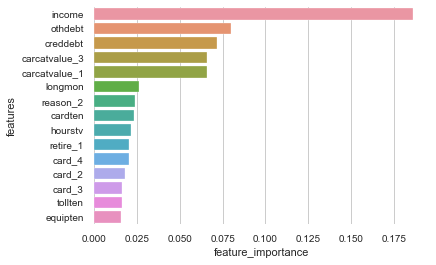

In [214]:
sns.barplot(x=best.feature_importance,y=best.features)

In [215]:
rand_reg.oob_score_

0.18993016641155613

### Key Drivers using random Forest

In [216]:
best['features']

64           income
74          othdebt
39         creddebt
18    carcatvalue_3
17    carcatvalue_1
71          longmon
87         reason_2
31          cardten
60          hourstv
91         retire_1
29           card_4
27           card_2
28           card_3
96          tollten
54         equipten
Name: features, dtype: object

### these are the top 15 Drivers
- income
- othdebt
- creddebt
- carcatvalue_3
- carcatvalue_1
- longmon
- reason_2
- cardten
- hourstv
- retire_1
- card_4
- card_2
- card_3
- tollten
- equipten